# 📚 <span style='color:#0D2BA5'>**Projet de Scoring de Crédit pour "Prêt à Dépenser"**

- ***Objectifs du Projet***

**L'objectif de ce projet est de construire un modèle prédictif performant qui permet d'évaluer la probabilité de remboursement d'un crédit par un client.**
- **Développer un algorithme de classification :** Exploiter diverses sources de données pour élaborer un modèle de scoring précis.
- **Analyser l'importance des caractéristiques :** Identifier les facteurs les plus influents dans les prédictions du modèle, à la fois globalement et localement.
- **Mise en production via une API :** Déployer le modèle de scoring à travers une API et créer une interface pour tester cette API.
- **Approche complète MLOps :** Établir un processus MLOps complet, incluant le suivi des expérimentations et l'analyse du data drift en production.
*****
- ***Approche et Outils Utilisés***

- **Utilisation des Kernels Kaggle pour l'analyse exploratoire, la préparation des données et le feature engineering.**
- **Outils et pratiques MLOps :** Intégration de MLFlow pour le suivi des expériences, la gestion des modèles et le serving. Utilisation de Git pour la gestion de version et de GitHub pour l'intégration et le déploiement continus, avec Pytest pour les tests unitaires.
- **Gestion du déséquilibre des données :** Prise en compte du déséquilibre entre les bons et les mauvais clients, ainsi que des coûts associés aux faux négatifs et faux positifs.
- **Optimisation et validation du modèle :** Application de techniques comme la Cross-Validation et GridsearchCV pour affiner le modèle.
- **Surveillance de la performance en production :** Emploi de la librairie 'evidently' pour détecter le data drift.
*****
- ***Résultats Attendus***

- **API de prédiction de score hébergée sur le cloud.**
- **Notebook Jupyter couvrant la modélisation, le prétraitement et la prédiction, intégrant MLFlow.**
- **Gestion du code et documentation via un outil de versioning et GitHub.**
- **Tableau HTML de data drift généré avec 'evidently'.**
- **Interface de test de l'API réalisée via un Notebook ou une application Streamlit.**
- **Présentation de la soutenance incluant des éléments visuels et des liens vers les ressources clés.**

## <a name="C1"><font color='RoyalBlue'> 1. Préparation des données</a>

In [3]:
import os
import zipfile

import pandas as pd
import numpy as np
import datetime as dt
import time
import gc
import re

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import glob
from contextlib import contextmanager
from IPython.display import Image, display

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [4]:
# Chemin du fichier ZIP
chemin_du_fichier_zip = 'Projet+Mise+en+prod+-+home-credit-default-risk.zip'
# Répertoire où les fichiers seront extraits
repertoire_extraction = './data/source/'

# Créer le répertoire d'extraction s'il n'existe pas
os.makedirs(repertoire_extraction, exist_ok=True)

# Extraire tous les fichiers du ZIP
with zipfile.ZipFile(chemin_du_fichier_zip, 'r') as zip_ref:
    zip_ref.extractall(repertoire_extraction)

print(f"Fichiers extraits dans : {repertoire_extraction}")

Fichiers extraits dans : ./data/source/


In [5]:
data = './data/source/'
os.listdir(data)

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

In [6]:
path = data
train = pd.read_csv(path + "application_train.csv")
test = pd.read_csv(path + "application_test.csv")
bureau = pd.read_csv(path + "bureau.csv")
bureau_equilibre = pd.read_csv(path + "bureau_balance.csv")
solde_pos_cash = pd.read_csv(path + "POS_CASH_balance.csv")
solde_carte_credit = pd.read_csv(path + "credit_card_balance.csv")
app_precedente = pd.read_csv(path + "previous_application.csv")
paiements_intermittents = pd.read_csv(path + "installments_payments.csv")
description_colonnes = pd.read_csv(path + "HomeCredit_columns_description.csv", encoding_errors='ignore')

In [7]:
# Liste des DataFrame
list_data= ["train", "test", "bureau", "bureau_equilibre",
           "solde_pos_cash", "solde_carte_credit", "app_precedente", "paiements_intermittents", "description_colonnes"]

In [8]:
path = glob.glob('./data/source/*.csv')

In [9]:
# Fonction pour afficher la taille d'un DataFrame
def afficher_taille(df, nom):
    nRow, nVar = df.shape
    print(f"Le jeu de données '{nom}' contient {nRow} lignes et {nVar} variables.")

# Afficher la taille de chaque DataFrame
afficher_taille(train, "train")
afficher_taille(test, "test")
afficher_taille(bureau, "bureau")
afficher_taille(bureau_equilibre, "bureau_equilibre")
afficher_taille(solde_pos_cash, "solde_pos_cash")
afficher_taille(solde_carte_credit, "solde_carte_credit")
afficher_taille(app_precedente, "app_precedente")
afficher_taille(paiements_intermittents, "paiements_intermittents")
afficher_taille(description_colonnes, "description_colonnes")

Le jeu de données 'train' contient 307511 lignes et 122 variables.
Le jeu de données 'test' contient 48744 lignes et 121 variables.
Le jeu de données 'bureau' contient 1716428 lignes et 17 variables.
Le jeu de données 'bureau_equilibre' contient 27299925 lignes et 3 variables.
Le jeu de données 'solde_pos_cash' contient 10001358 lignes et 8 variables.
Le jeu de données 'solde_carte_credit' contient 3840312 lignes et 23 variables.
Le jeu de données 'app_precedente' contient 1670214 lignes et 37 variables.
Le jeu de données 'paiements_intermittents' contient 13605401 lignes et 8 variables.
Le jeu de données 'description_colonnes' contient 219 lignes et 5 variables.


## <a name="C1"><font color='RoyalBlue'> 2. Description des fichiers

In [11]:
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

**Les données sont fournies par "Home Credit", un service dédié à l'octroi de crédits (prêts) à la population non bancarisée. Prédire si un client remboursera un prêt ou aura des difficultés est un besoin commercial crucial, et Home Credit organise ce concours sur Kaggle pour voir quels types de modèles la communauté de l'apprentissage automatique peut développer pour les aider dans cette tâche.**


***Description des datasets :***

**application_{train|test}.csv**

- **Description :** Cette table contient les informations principales sur les demandes de prêt des clients. Elle est divisée en deux parties : application_train.csv pour les données d'entraînement et application_test.csv pour les données de test.

- ***Principales Features :***
- SK_ID_CURR : Identifiant unique pour chaque client.
- TARGET : Indicateur binaire indiquant si le client a fait défaut sur le prêt (1) ou non (0) (présent uniquement dans application_train.csv).
- Informations sur le prêt et le demandeur : Montant du prêt, revenu total, âge du demandeur, etc.

**bureau.csv**

- **Description :** Cette table contient des données sur les prêts précédents que le client a obtenus auprès d'autres institutions et qui ont été signalés au bureau de crédit.

- ***Principales Features :***
- SK_ID_CURR : Identifiant unique pour chaque client.
- SK_ID_BUREAU : Identifiant unique pour chaque prêt répertorié dans le bureau de crédit.
- Détails du prêt : Montant du crédit, jours de retard, statut du crédit (actif, fermé), etc.

**bureau_balance.csv**

- **Description :** Cette table contient des informations sur le solde mensuel des prêts répertoriés dans le bureau de crédit.

- ***Principales Features :***
- SK_ID_BUREAU : Identifiant unique pour chaque prêt répertorié dans le bureau de crédit.
- MONTHS_BALANCE : Mois du solde relatif au mois actuel.
- Données comportementales : Jours de retard de paiement (DPD), etc.

**previous_application.csv**

- **Description :** Cette table contient des informations sur les demandes de prêt précédentes des clients auprès de Home Credit.

***Principales Features :***
- SK_ID_CURR : Identifiant unique pour chaque client.
- SK_ID_PREV : Identifiant unique pour chaque demande de prêt précédente.
- Détails de la demande : Montant demandé, montant du crédit, statut du contrat (approuvé, refusé), etc.

**POS_CASH_balance.csv**

- **Description :** Cette table contient des informations sur le solde mensuel des prêts précédents des clients auprès de Home Credit, spécifiquement pour les prêts POS (Point of Sale) et CASH.

- ***Principales Features :***
- SK_ID_CURR : Identifiant unique pour chaque client.
- SK_ID_PREV : Identifiant unique pour chaque prêt précédent.
- MONTHS_BALANCE : Mois du solde relatif au mois actuel.
- Données comportementales : Jours de retard de paiement (DPD), etc.
  
**installments_payments.csv**

- **Description :** Cette table contient des données sur les paiements passés pour chaque crédit antérieur du client auprès de Home Credit.

***Principales Features :***
- SK_ID_CURR : Identifiant unique pour chaque client.
- SK_ID_PREV : Identifiant unique pour chaque prêt précédent.
- Détails des paiements : Montant de l'échéance, montant payé, jours de retard de paiement, etc.

**credit_card_balance.csv**

- **Description :** Cette table contient des informations sur le solde mensuel des prêts sur carte de crédit des clients auprès de Home Credit.

- ***Principales Features :***
- SK_ID_CURR : Identifiant unique pour chaque client.
- SK_ID_PREV : Identifiant unique pour chaque prêt précédent.
- MONTHS_BALANCE : Mois du solde relatif au mois actuel.
- Données comportementales : Limite de crédit, montant dû, jours de retard de paiement (DPD), etc.
  
***Relations entre les tables***
- SK_ID_CURR : Cette clé primaire est utilisée pour relier les informations des clients entre les différentes tables.
- SK_ID_PREV : Utilisée pour relier les informations sur les prêts précédents entre les tables previous_application.csv, POS_CASH_balance.csv, -----   installments_payments.csv, et credit_card_balance.csv.
- SK_ID_BUREAU : Utilisée pour relier les informations entre bureau.csv et bureau_balance.csv

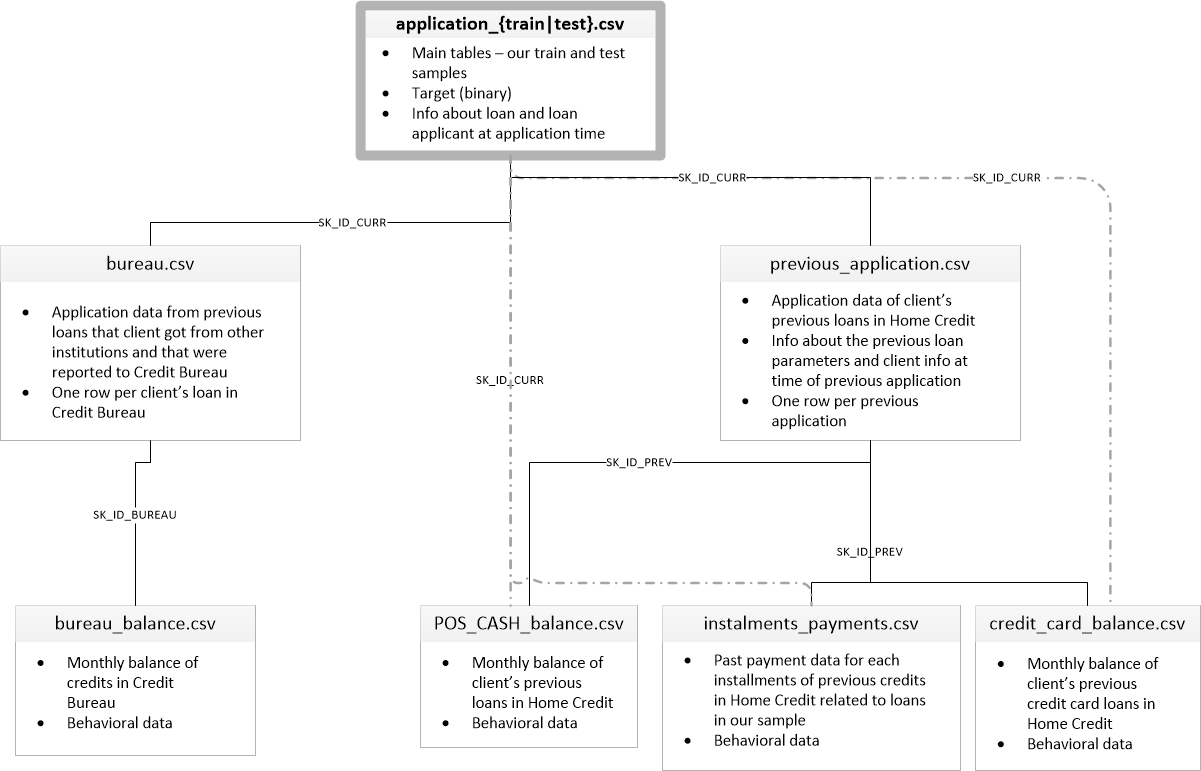

In [13]:
image_path = 'home_credit.png'  
display(Image(filename=image_path))

***Le schéma représente les relations entre les différentes tables de données fournies par Home Credit pour le problème de prédiction de risque de défaut de crédit.***

## <span style='background:PowderBlue'> 1. Fonctions utiles pour l'analyse

**Nous utiliserons le kernel Kaggle suivant, que nous adapterons à nos besoins : https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script**

### <a name="C2"><font color='RoyalBlue'> 1.1 Analyse et Résumé des Fichiers CSV

In [18]:
# Définir le chemin des fichiers
path = './data/source/'

In [19]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [20]:
def data_describe(folder):
    '''Check the number of rows, columns, missing values and duplicates.
       Count type of columns.
       Memory indication'''

    data_dict = {}
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        if os.path.isfile(file_path) and file.endswith('.csv'):
            print("Processing ", file, ":")
            data = pd.read_csv(file_path, encoding_errors='ignore')
            data_dict[file] = [data.shape[0], 
                               data.shape[1],
                               round(data.isna().sum().sum() / data.size * 100, 2),
                               round(data.duplicated().sum() / data.size * 100, 2),
                               data.select_dtypes(include=['object']).shape[1],
                               data.select_dtypes(include=['float']).shape[1],
                               data.select_dtypes(include=['int']).shape[1],
                               data.select_dtypes(include=['bool']).shape[1],
                               round(data.memory_usage().sum() / 1024**2, 3)]

    comparative_table = pd.DataFrame.from_dict(data=data_dict, 
                                               columns=['Rows', 'Columns', '%NaN', '%Duplicate', 
                                                        'object_dtype', 'float_dtype', 'int_dtype', 
                                                        'bool_dtype', 'MB_Memory'], 
                                               orient='index')
    print("SUMMARY FILES…")
    return comparative_table

### <a name="C2"><font color='RoyalBlue'> 1.2 Analyse des features des Fichiers CSV

In [22]:
def features(folder):
    '''Comparative data with missing values, 
       and many descriptive statistics.'''
    
    data_object = {}
    data_numeric = {}
    
    for file in folder:
        data = pd.read_csv(file, encoding_errors='ignore')
        
        data_object[file] = [(x, data[x].dtype, 
                              data[x].isna().sum().sum(),
                              int(data[x].count())) for x in data.select_dtypes(exclude=['int', 'float'])]
        
        data_numeric[file] = [(x, data[x].dtype, 
                               int(data[x].isna().sum().sum()), 
                               int(data[x].count()), 
                               int(data[x].mean()), 
                               round(data[x].std(),1),
                               round(data[x].min(),1), 
                               round(data[x].max(),1)) for x in data.select_dtypes(exclude='object')]
        

    comparative_object = pd.DataFrame.from_dict(data = data_object, orient='index')
    dict_of_object = {name: pd.DataFrame(file) for name,file in data_object.items()}
    df1 = pd.concat(dict_of_object, axis=0)
    df1.columns=['features','dtype','nan','count']
    
    comparative_numeric = pd.DataFrame.from_dict(data = data_numeric, orient='index')
    dict_of_numeric = {name: pd.DataFrame(file) for name,file in data_numeric.items()}
    df2 = pd.concat(dict_of_numeric, axis=0)
    df2.columns=['features','dtype','nan','count', 'mean', 'std', 'min','max']
        
    return df1, df2

### <a name="C2"><font color='RoyalBlue'> 1.3 Analyse des valeurs manquantes

In [24]:
def missing_values(data, plot=False):
    mst = pd.DataFrame(
        {"Num_Missing": data.isnull().sum(), 
         "Missing_Ratio": data.isnull().sum() / data.shape[0]}).sort_values(
        "Num_Missing", ascending=False)
    mst["DataTypes"] = data[mst.index].dtypes.values
    mst = mst[mst.Num_Missing > 0].reset_index().rename(
        {"index": "Feature"}, axis=1)

    print("Number of Variables including Missing Values:", mst.shape[0], "\n")

    if mst[mst.Missing_Ratio >= 1.0].shape[0] > 0:
        print("Full Missing Variables:",
              mst[mst.Missing_Ratio >= 1.0].Feature.tolist())
        data.drop(mst[mst.Missing_Ratio >= 1.0].Feature.tolist(),
                  axis=1, inplace=True)

        print("Full missing variables are deleted!", "\n")

    if plot:
        plt.figure(figsize=(25, 8))
        p = sns.barplot(mst.Feature, mst.Missing_Ratio)
        for rotate in p.get_xticklabels():
            rotate.set_rotation(90)
        plt.show()

    print(mst, "\n")

### <a name="C2"><font color='RoyalBlue'> 1.4 Encodage One Hot pour les caractéristiques catégorielles (avec get_dummies)

In [26]:
# Fonction d'encodage One-Hot
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

### <a name="C2"><font color='RoyalBlue'> 1.5 Preprocessing des fichiers application_train.csv et application_test.csv

In [28]:
# Fonction de lecture et de fusion des jeux de données d'entraînement et de test
def application_train_test(num_rows=None, nan_as_category=False):
    # Lire les données et fusionner train et test (test : Target = NAN après la fusion)
    df = pd.read_csv(path + 'application_train.csv', nrows=num_rows)
    test_df = pd.read_csv(path + 'application_test.csv', nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    
    # Utiliser pd.concat au lieu de df.append
    df = pd.concat([df, test_df], ignore_index=True)
    
    # Optionnel : Supprimer 4 applications avec CODE_GENDER = 'XNA' (jeu d'entraînement)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Caractéristiques catégorielles avec encodage binaire (sortie = 0 ou 1 ; deux catégories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    
    # Caractéristiques catégorielles avec encodage One-Hot
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # Valeurs NaN pour DAYS_EMPLOYED : 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    
    # Quelques nouvelles caractéristiques simples (pourcentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    del test_df
    gc.collect()
    
    return df

### <a name="C2"><font color='RoyalBlue'> 1.6 Preprocessing des fichiers bureau.csv et bureau_balance.csv

In [30]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(path + 'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(path + 'bureau_balance.csv', nrows = num_rows)
    # OHE bureau_balance.csv
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    # OHE bureau.csv
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
   # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
        
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

### <a name="C2"><font color='RoyalBlue'> 1.7 Preprocessing du fichier previous_applications.csv

In [32]:
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(path + 'previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

### <a name="C2"><font color='RoyalBlue'> 1.8 Preprocessing du fichier POS_CASH_balance.csv

In [34]:
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(path + 'POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

### <a name="C2"><font color='RoyalBlue'> 1.9 Preprocessing du fichier installments_payments.csv

In [36]:
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(path + 'installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

### <a name="C2"><font color='RoyalBlue'> 1.10 Preprocessing du fichier credit_card_balance.csv

In [38]:
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(path + 'credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

### <a name="C2"><font color='RoyalBlue'> 1.11 Fusion des Données

In [40]:
# Fonction principale pour lier les différentes étapes et afficher le DataFrame résultant
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        return df
        gc.collect()

## <span style='background:PowderBlue'> 2. Analyse Exploratoire Des Données

Pour effectuer notre analyse exploratoire des données (EDA), nous utilisons les kernels Kaggle suivants, que nous adaptons aux besoins de notre analyse :  https://www.kaggle.com/code/gpreda/home-credit-default-risk-extensive-eda et https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction

In [43]:
path = './data/source/'

# Appel de la fonction `data_describe`
data_describe(path)

Processing  application_test.csv :
Processing  application_train.csv :
Processing  bureau.csv :
Processing  bureau_balance.csv :
Processing  credit_card_balance.csv :
Processing  HomeCredit_columns_description.csv :
Processing  installments_payments.csv :
Processing  POS_CASH_balance.csv :
Processing  previous_application.csv :
Processing  sample_submission.csv :
SUMMARY FILES…


,Rows,Columns,%NaN,%Duplicate,object_dtype,float_dtype,int_dtype,bool_dtype,MB_Memory
application_test.csv,48744,121,23.81,0.0,16,65,40,0,44.998
application_train.csv,307511,122,24.40,0.0,16,65,41,0,286.227
bureau.csv,1716428,17,13.50,0.0,3,8,6,0,222.620
bureau_balance.csv,27299925,3,0.00,0.0,1,0,2,0,624.846
credit_card_balance.csv,3840312,23,6.65,0.0,1,15,7,0,673.883
HomeCredit_columns_description.csv,219,5,12.15,0.0,4,0,1,0,0.008
installments_payments.csv,13605401,8,0.01,0.0,0,5,3,0,830.408
POS_CASH_balance.csv,10001358,8,0.07,0.0,1,2,5,0,610.435
previous_application.csv,1670214,37,17.98,0.0,16,15,6,0,471.481
sample_submission.csv,48744,2,0.00,0.0,0,1,1,0,0.744


In [44]:
# Appel la fonction 'features'
features(folder=glob.glob('./data/source/*.csv'))[0]

features  \
./data/source\application_test.csv               0            NAME_CONTRACT_TYPE   
                                                 1                   CODE_GENDER   
                                                 2                  FLAG_OWN_CAR   
                                                 3               FLAG_OWN_REALTY   
                                                 4               NAME_TYPE_SUITE   
                                                 5              NAME_INCOME_TYPE   
                                                 6           NAME_EDUCATION_TYPE   
                                                 7            NAME_FAMILY_STATUS   
                                                 8             NAME_HOUSING_TYPE   
                                                 9               OCCUPATION_TYPE   
                                                 10   WEEKDAY_APPR_PROCESS_START   
                                                 11            ORGANIZATION_TYPE   
                                                 12           FONDKAPREMONT_MODE   
                                                 13               HOUSETYPE_MODE   
                                                 14           WALLSMATERIAL_MODE   
                                                 15          EMERGENCYSTATE_MODE   
./data/source\application_train.csv              0            NAME_CONTRACT_TYPE   
                                                 1                   CODE_GENDER   
                                                 2                  FLAG_OWN_CAR   
                                                 3               FLAG_OWN_REALTY   
                                                 4               NAME_TYPE_SUITE   
                                                 5              NAME_INCOME_TYPE   
                                                 6           NAME_EDUCATION_TYPE   
                                                 7            NAME_FAMILY_STATUS   
                                                 8             NAME_HOUSING_TYPE   
                                                 9               OCCUPATION_TYPE   
                                                 10   WEEKDAY_APPR_PROCESS_START   
                                                 11            ORGANIZATION_TYPE   
                                                 12           FONDKAPREMONT_MODE   
                                                 13               HOUSETYPE_MODE   
                                                 14           WALLSMATERIAL_MODE   
                                                 15          EMERGENCYSTATE_MODE   
./data/source\bureau.csv                         0                 CREDIT_ACTIVE   
                                                 1               CREDIT_CURRENCY   
                                                 2                   CREDIT_TYPE   
./data/source\bureau_balance.csv                 0                        STATUS   
./data/source\credit_card_balance.csv            0          NAME_CONTRACT_STATUS   
./data/source\HomeCredit_columns_description.csv 0                         Table   
                                                 1                           Row   
                                                 2                   Description   
                                                 3                       Special   
./data/source\POS_CASH_balance.csv               0          NAME_CONTRACT_STATUS   
./data/source\previous_application.csv           0            NAME_CONTRACT_TYPE   
                                                 1    WEEKDAY_APPR_PROCESS_START   
                                                 2   FLAG_LAST_APPL_PER_CONTRACT   
                                                 3        NAME_CASH_LOAN_PURPOSE   
                                                 4          NAME_CONTRACT_STATUS   
                                        

In [45]:
features(folder=glob.glob('./data/source/*.csv'))[1]

features  \
./data/source\application_test.csv               0                      SK_ID_CURR   
                                                 1                    CNT_CHILDREN   
                                                 2                AMT_INCOME_TOTAL   
                                                 3                      AMT_CREDIT   
                                                 4                     AMT_ANNUITY   
                                                 5                 AMT_GOODS_PRICE   
                                                 6      REGION_POPULATION_RELATIVE   
                                                 7                      DAYS_BIRTH   
                                                 8                   DAYS_EMPLOYED   
                                                 9               DAYS_REGISTRATION   
                                                 10                DAYS_ID_PUBLISH   
                                                 11                    OWN_CAR_AGE   
                                                 12                     FLAG_MOBIL   
                                                 13                 FLAG_EMP_PHONE   
                                                 14                FLAG_WORK_PHONE   
                                                 15               FLAG_CONT_MOBILE   
                                                 16                     FLAG_PHONE   
                                                 17                     FLAG_EMAIL   
                                                 18                CNT_FAM_MEMBERS   
                                                 19           REGION_RATING_CLIENT   
                                                 20    REGION_RATING_CLIENT_W_CITY   
                                                 21        HOUR_APPR_PROCESS_START   
                                                 22     REG_REGION_NOT_LIVE_REGION   
                                                 23     REG_REGION_NOT_WORK_REGION   
                                                 24    LIVE_REGION_NOT_WORK_REGION   
                                                 25         REG_CITY_NOT_LIVE_CITY   
                                                 26         REG_CITY_NOT_WORK_CITY   
                                                 27        LIVE_CITY_NOT_WORK_CITY   
                                                 28                   EXT_SOURCE_1   
                                                 29                   EXT_SOURCE_2   
                                                 30                   EXT_SOURCE_3   
                                                 31                 APARTMENTS_AVG   
                                                 32               BASEMENTAREA_AVG   
                                                 33    YEARS_BEGINEXPLUATATION_AVG   
                                                 34                YEARS_BUILD_AVG   
                                                 35                 COMMONAREA_AVG   
                                                 36                  ELEVATORS_AVG   
                                                 37                  ENTRANCES_AVG   
                                                 38                  FLOORSMAX_AVG   
                                                 39                  FLOORSMIN_AVG   
                                                 40                   LANDAREA_AVG   
                                                 41           LIVINGAPARTMENTS_AVG   
                                                 42                 LIVINGAREA_AVG   
                                                 43        NONLIVINGAPARTMENTS_AVG   
                                                 44              NONLIVINGAREA_AVG   
                                                 45                APARTMENTS_MODE   
                                

In [46]:
#Afficher les dataframes
for df in list_data:
    print("="*20)
    print((df), "| head |", "-"*20)
    display(eval(df).head())
    print((df), "| tail |", "-"*20)
    display(eval(df).tail())
    print("_"*20)

train | head | --------------------


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

train | tail | --------------------


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032561,-9327,-236,-8456.0,-1982,NaN,1,1,0,1,0,0,Sales staff,1.0,1,1,THURSDAY,15,0,0,0,0,0,0,Services,0.145570,0.681632,NaN,0.2021,0.0887,0.9876,0.8300,0.0202,0.22,0.1034,0.6042,0.2708,0.0594,0.1484,0.1965,0.0753,0.1095,0.1008,0.0172,0.9782,0.7125,0.0172,0.0806,0.0345,0.4583,0.0417,0.0094,0.0882,0.0853,0.0,0.0125,0.2040,0.0887,0.9876,0.8323,0.0203,0.22,0.1034,0.6042,0.2708,0.0605,0.1509,0.2001,0.0757,0.1118,reg oper account,block of flats,0.2898,"Stone, brick",No,0.0,0.0,0.0,0.0,-273.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025164,-20775,365243,-4388.0,-4090,NaN,1,0,0,1,1,0,NaN,1.0,2,2,MONDAY,8,0,0,0,0,0,0,XNA,NaN,0.115992,NaN,0.0247,0.0435,0.9727,0.6260,0.0022,0.00,0.1034,0.0833,0.1250,0.0579,0.0202,0.0257,0.0000,0.0000,0.0252,0.0451,0.9727,0.6406,0.0022,0.0000,0.1034,0.0833,0.1250,0.0592,0.0220,0.0267,0.0,0.0000,0.0250,0.0435,0.9727,0.6310,0.0022,0.00,0.1034,0.0833,0.1250,0.0589,0.0205,0.0261,0.0000,0.0000,reg oper account,block of flats,0.0214,"Stone, brick",No,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,Working,Higher education,Separated,House / apartment,0.005002,-14966,-7921,-6737.0,-5150,NaN,1,1,0,1,0,1,Managers,1.0,3,3,THURSDAY,9,0,0,0,0,1,1,School,0.744026,0.535722,0.218859,0.1031,0.0862,0.9816,0.7484,0.0123,0.00,0.2069,0.1667,0.2083,NaN,0.0841,0.9279,0.0000,0.0000,0.1050,0.0894,0.9816,0.7583,0.0124,0.0000,0.2069,0.1667,0.2

____________________
test | head | --------------------


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

test | tail | --------------------


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,Unaccompanied,Working,Secondary / secondary special,Widow,House / apartment,0.002042,-19970,-5169,-9094.0,-3399,NaN,1,1,1,1,1,0,NaN,1.0,3,3,WEDNESDAY,16,0,0,0,0,0,0,Other,NaN,0.648575,0.643026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-684.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.035792,-11186,-1149,-3015.0,-3003,NaN,1,1,0,1,0,0,Sales staff,4.0,2,2,MONDAY,11,0,0,0,0,1,1,Trade: type 7,NaN,0.684596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.026392,-15922,-3037,-2681.0,-1504,4.0,1,1,0,1,1,0,NaN,3.0,2,2,WEDNESDAY,12,0,0,0,0,0,0,Business Entity Type 3,0.733503,0.632770,0.283712,0.1113,0.1364,0.9955,NaN,NaN,0.16,0.1379,0.3333,NaN,NaN,NaN,0.1383,NaN,0.0542,0.1134,0.1415,0.9955,NaN,NaN,0.1611,0.1379,0.3333,NaN,NaN,NaN,0.1441,NaN,0.0574,0.1124,0.1364,0.9955,NaN,NaN,0.16,0.1379,0.3333,NaN,NaN,NaN,0.1408,NaN,0.0554,NaN,block of flats,0.1663,"Stone, brick",No,0.0,0.0,0.0,0.0,-838.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,2

____________________
bureau | head | --------------------


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


bureau | tail | --------------------


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN
1716427,246829,5057778,Closed,currency 1,-463,0,NaN,-387.0,NaN,0,22500.00,0.0,NaN,0.0,Microloan,-387,NaN


____________________
bureau_equilibre | head | --------------------


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


bureau_equilibre | tail | --------------------


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X
27299924,5041336,-51,X


____________________
solde_pos_cash | head | --------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


solde_pos_cash | tail | --------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0
10001357,1259607,174278,-52,16.0,0.0,Completed,0,0


____________________
solde_carte_credit | head | --------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


solde_carte_credit | tail | --------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.0,NaN,0.000,0.00,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.0,1879.11,0.000,0.00,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.0,375750.00,356994.675,269356.14,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.0,NaN,0.000,0.00,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840311,2411345,236760,-10,0.000,157500,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.00,0.000,0.000,0.0,0,0.0,0.0,21.0,Completed,0,0


____________________
app_precedente | head | --------------------


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


app_precedente | tail | --------------------


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,Y,1,0.000000,NaN,NaN,XAP,Approved,-544,Cash through the bank,XAP,NaN,Refreshed,Furniture,POS,XNA,Stone,43,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,Y,1,0.340554,NaN,NaN,XAP,Approved,-1694,Cash through the bank,XAP,Unaccompanied,New,Furniture,POS,XNA,Stone,43,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,Y,1,0.101401,NaN,NaN,XAP,Approved,-1488,Cash through the bank,XAP,"Spouse, partner",Repeater,Consumer Electronics,POS,XNA,Country-wide,1370,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,Y,1,NaN,NaN,NaN,XNA,Approved,-1185,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0
1670213,2418762,261212,Cash loans,16431.300,360000.0,360000.0,NaN,360000.0,SUNDAY,10,Y,1,NaN,NaN,NaN,XNA,Approved,-1193,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,48.0,middle,Cash X-Sell: middle,365243.0,-1163.0,247.0,-443.0,-423.0,0.0


____________________
paiements_intermittents | head | --------------------


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


paiements_intermittents | tail | --------------------


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN
13605400,2448869,434321,1.0,19,-27.0,NaN,11504.250,NaN


____________________
description_colonnes | head | --------------------


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


description_colonnes | tail | --------------------


,Unnamed: 0,Table,Row,Description,Special
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN
218,221,installments_payments.csv,AMT_PAYMENT,What the client actually paid on previous cred...,NaN


____________________


In [47]:
# Affichage des informations essentielles des DataFrames
for df in list_data:
    print((df), "-"*20)
    print("rows x columns =", eval(df).shape)
    print("missing values(%) = ", eval(df).isnull().mean().mean())
    print(eval(df).columns)
    print("\n","="*20)

train --------------------
rows x columns = (307511, 122)
missing values(%) =  0.24395941907129431
Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

test --------------------
rows x columns = (48744, 121)
missing values(%) =  0.23811686761532333
Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_D

In [48]:
# Déterminons le ratio entre le jeu d'entraînement train et test
print("test / train rate =", round(test.shape[0] / (train.shape[0] + test.shape[0]),2))

test / train rate = 0.14


***Le résultat signifie que la proportion des données de test par rapport à l'ensemble des données (entraînement + test) est de 14%.Cela peut être utile pour évaluer la répartition des données avant de procéder à l'entraînement d'un modèle de machine learning.***

### <a name="C2"><font color='RoyalBlue'> 2.1 Création du jeu de données des caractéristiques principales

In [51]:
path = './data/source/'

In [52]:
with timer("Full model run"):
    df = main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 18s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 18s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 10s
Installments payments df shape: (339587, 26)
Process installments payments - done in 28s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 16s
Full model run - done in 95s


In [53]:
df

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           100002     1.0            0             0                0   
1           100003     0.0            1             0                1   
2           100004     0.0            0             1                0   
3           100006     0.0            1             0                0   
4           100007     0.0            0             0                0   
...            ...     ...          ...           ...              ...   
356250      456221     NaN            1             0                0   
356251      456222     NaN            1             0                1   
356252      456223     NaN            1             1                0   
356253      456224     NaN            0             0                1   
356254      456250     NaN            1             1                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
356250             0          121500.0    412560.0      17473.5   
356251             2          157500.0    622413.0      31909.5   
356252             1          202500.0    315000.0      33205.5   
356253             0          225000.0    450000.0      25128.0   
356254             0          135000.0    312768.0      24709.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0              351000.0                    0.018801       -9461   
1             1129500.0                    0.003541      -16765   
2              135000.0                    0.010032      -19046   
3              297000.0                    0.008019      -19005   
4              513000.0                    0.028663      -19932   
...                 ...                         ...         ...   
356250         270000.0                    0.002042      -19970   
356251         495000.0                    0.035792      -11186   
356252         315000.0                    0.026392      -15922   
356253         450000.0                    0.018850      -13968   
356254         270000.0                    0.006629      -13962   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0              -637.0            -3648.0            -2120          NaN   
1             -1188.0            -1186.0             -291          NaN   
2              -225.0            -4260.0            -2531         26.0   
3             -3039.0            -9833.0            -2437          NaN   
4             -3038.0            -4311.0            -3458          NaN   
...               ...                ...              ...          ...   
356250        -5169.0            -9094.0            -3399          NaN   
356251        -1149.0            -3015.0            -3003          NaN   
356252        -3037.0            -2681.0            -1504          4.0   
356253        -2731.0            -1461.0            -1364          NaN   
356254         -633.0            -1072.0            -4220         22.0   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
0                1               1                0                 1   
1                1               1                0                 1   
2                1               1                1                 1   
3                1               1                0                 1   
4                1               1                0                 1   
...            ...             ...              ...               ...   
356250           1               1                1                 1   
356251           1               1  

In [54]:
df.describe()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_ANNUITY_MAX,BURO_AMT_ANNUITY_MEAN,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_MIN_MIN,BURO_MONTHS_BALANCE_MAX_MAX,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Bad debt_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,BURO_CREDIT_ACTIVE_nan_MEAN,BURO_CREDIT_CURRENCY_currency 1_MEAN,BURO_CREDIT_CURRENCY_currency 2_MEAN,BURO_CREDIT_CURRENCY_currency 3_MEAN,BURO_CREDIT_CURRENCY_currency 4_MEAN,BURO_CREDIT_CURRENCY_nan_MEAN,BURO_CREDIT_TYPE_Another type of loan_MEAN,BURO_CREDIT_TYPE_Car loan_MEAN,BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,BURO_CREDIT_TYPE_Consumer credit_MEAN,BURO_CREDIT_TYPE_Credit card_MEAN,BURO_CREDIT_TYPE_Interbank credit_MEAN,BURO_CREDIT_TYPE_Loan for business development_MEAN,BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_TYPE_Mobile operator loan_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_CREDIT_TYPE_Real estate loan_MEAN,BURO_CREDIT_TYPE_Unknown type of loan_MEAN,BURO_CREDIT_TYPE_nan_MEAN,BURO_STATUS_0_MEAN_MEAN,BURO_STATUS_1_MEAN_MEAN,BURO_STATUS_2_MEAN_MEAN,BURO_STATUS_3_MEAN_MEAN,BURO_STATUS_4_MEAN_MEAN,BURO_STATUS_5_MEAN_MEAN,BURO_STATUS_C_MEAN_MEAN,BURO_STATUS_X_MEAN_MEAN,BURO_STATUS_n

In [55]:
df.columns.sort_values().to_list()

['ACTIVE_AMT_ANNUITY_MAX',
 'ACTIVE_AMT_ANNUITY_MEAN',
 'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MAX',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM',
 'ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM',
 'ACTIVE_AMT_CREDIT_SUM_MAX',
 'ACTIVE_AMT_CREDIT_SUM_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'ACTIVE_CNT_CREDIT_PROLONG_SUM',
 'ACTIVE_CREDIT_DAY_OVERDUE_MAX',
 'ACTIVE_CREDIT_DAY_OVERDUE_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'ACTIVE_DAYS_CREDIT_MAX',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'ACTIVE_DAYS_CREDIT_MIN',
 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
 'ACTIVE_DAYS_CREDIT_VAR',
 'ACTIVE_MONTHS_BALANCE_MAX_MAX',
 'ACTIVE_MONTHS_BALANCE_MIN_MIN',
 'ACTIVE_MONTHS_BALANCE_SIZE_MEAN',
 'ACTIVE_MONTHS_BALANCE_SIZE_SUM',
 'AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'A

## <span style='background:PowderBlue'>3. Exploration du Jeu de Données d'Entraînement

In [57]:
# Nombre de chaque type de colonne
nombre_de_types_de_colonnes = train.dtypes.value_counts()
print(nombre_de_types_de_colonnes)

float64    65
int64      41
object     16
Name: count, dtype: int64


In [58]:
def data_structure(df):
    ''' Affiche la structure du dataframe'''
    
    # Comptage des colonnes numériques et catégorielles
    numeric_columns = len(df.select_dtypes(include=['int64', 'float64']).columns)
    categorical_columns = len(df.select_dtypes(include=['object', 'category']).columns)

    # Calcul du pourcentage de données manquantes
    missing_percentage = df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100

    # Création d'un dictionnaire avec les éléments de structure de nos données
    dict_structure = {
        'Nombre de lignes': df.shape[0],
        'Nombre de colonnes': df.shape[1],
        'Nombre de variables catégorielles': categorical_columns,
        'Nombre de variables numériques': numeric_columns,
        'Pourcentage de données manquantes': round(missing_percentage, 2),
        'Nombre de doublons': df.duplicated().sum(),
    }

    return dict_structure

In [59]:
# Affichage de la structure du DataFrame
data_structure(df)

{'Nombre de lignes': 356251,
 'Nombre de colonnes': 797,
 'Nombre de variables catégorielles': 16,
 'Nombre de variables numériques': 648,
 'Pourcentage de données manquantes': 25.39,
 'Nombre de doublons': 0}

In [60]:
def nan_check(data):
    '''Check Missing Values'''
    total = data.isnull().sum()
    percent_1 = data.isnull().mean()*100
    percent_2 = (np.round(percent_1, 2))
    missing_data = pd.concat([total, percent_2], 
                             axis=1, keys=['Total', '%']).sort_values('%', ascending=False)
    return missing_data

In [61]:
print("Nombre de colonnes dans l'échantillon d'entraînement : " + str(len(nan_check(train))))

print("Nombre de colonnes dans l'échantillon d'entraînement avec des valeurs manquantes : " + 
      str(len(nan_check(train)[nan_check(train)['Total'] != 0])))

Nombre de colonnes dans l'échantillon d'entraînement : 122
Nombre de colonnes dans l'échantillon d'entraînement avec des valeurs manquantes : 67


In [62]:
print('TOP 10 des valeurs manquantes dans le jeu de données d\'entraînement')
nan_check(train)[:10]

TOP 10 des valeurs manquantes dans le jeu de données d'entraînement


,Total,%
COMMONAREA_MEDI,214865,69.87
COMMONAREA_AVG,214865,69.87
COMMONAREA_MODE,214865,69.87
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
NONLIVINGAPARTMENTS_MEDI,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_MODE,210199,68.35
LIVINGAPARTMENTS_AVG,210199,68.35
LIVINGAPARTMENTS_MEDI,210199,68.35


In [63]:
print('TOP 10 des colonnes avec des valeurs manquantes dans le dataset')
nan_check(df)[:10]

TOP 10 des colonnes avec des valeurs manquantes dans le dataset


,Total,%
REFUSED_AMT_DOWN_PAYMENT_MIN,303648,85.23
REFUSED_RATE_DOWN_PAYMENT_MIN,303648,85.23
REFUSED_RATE_DOWN_PAYMENT_MEAN,303648,85.23
REFUSED_AMT_DOWN_PAYMENT_MEAN,303648,85.23
REFUSED_RATE_DOWN_PAYMENT_MAX,303648,85.23
REFUSED_AMT_DOWN_PAYMENT_MAX,303648,85.23
REFUSED_APP_CREDIT_PERC_VAR,298034,83.66
CC_AMT_PAYMENT_CURRENT_VAR,284649,79.90
CC_AMT_DRAWINGS_ATM_CURRENT_VAR,284559,79.88
CC_CNT_DRAWINGS_POS_CURRENT_VAR,284559,79.88


## <font color='Blue'> Fonctions pour analyser les features clés

In [65]:
# Fonction pour tracer les diagrammes en barre
def plot_stat(data, feature, title) : 
    
    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sns.countplot(y=feature, data=data, order=data[feature].value_counts(ascending=False).index)
    ax.set_title(title)

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(data[feature]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    plt.show()

In [66]:
# Fonction pour Tracer le Pourcentage de la Cible avec Valeur 1 par Catégorie
def plot_percent_target1(data, feature, title) : 
    
    cat_perc = data[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sns.barplot(y=feature, x='TARGET', data=cat_perc)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Percent of target with value 1")

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width())
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    plt.show()

### <a name="C2"><font color='RoyalBlue'> 3.1 Analyse de la Cible

Répartition de la target :

- 0 : le prêt a été remboursé
- 1 : le prêt n'a pas été remboursé

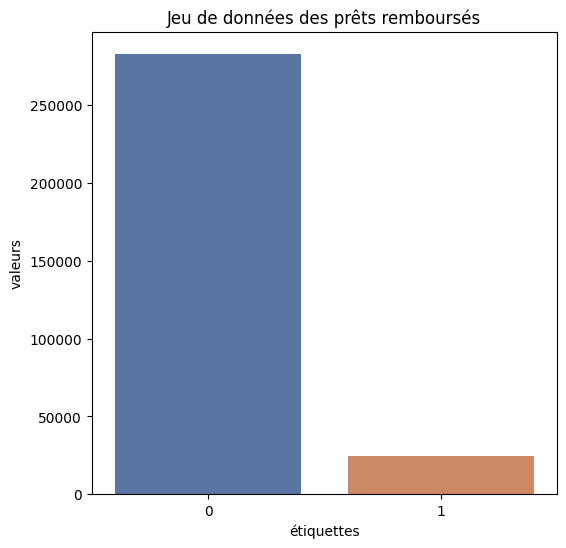

In [69]:
temp = train["TARGET"].value_counts()
df0 = pd.DataFrame({'étiquettes': temp.index,
                   'valeurs': temp.values
                  })

plt.figure(figsize = (6,6))
plt.title('Jeu de données des prêts remboursés')
sns.barplot(x = 'étiquettes', y="valeurs", data=df0, palette='deep')
plt.show()

***La majorité des prêts dans le jeu de données d'entraînement sont remboursés (0), tandis qu'une petite fraction n'est pas remboursée (1),d'ou un déséquilibre significatif entre les deux catégories.***

#### <font color='Blue'> Types de prêts

***Analysons les différentes catégories de prêts contractés et visualisons le pourcentage de chaque type de prêt ayant une valeur Target de 1 (indiquant les prêts non remboursés).***

In [73]:
#F onction pour tracer deux graphiques en barres côte à côte ou superposés : 
# l'un montrant le nombre de contrats par catégorie d'une caractéristique donnée,
# et l'autre montrant le pourcentage de TARGET égal à 1 pour chaque catégorie de cette caractéristique

def plot_stat(feature, rotation_labels=False, disposition_horizontale=True):
    temp = train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index, 'Nombre de contrats': temp.values})
    df1['Pourcentage'] = 100 * df1['Nombre de contrats'] / df1['Nombre de contrats'].sum()

    # Calculer le pourcentage de target=1 par catégorie
    cat_perc = train[[feature, 'TARGET']].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    cat_perc['Pourcentage'] = 100 * cat_perc['TARGET']

    if disposition_horizontale:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 14))

    # Choix des palettes de couleurs
    palette1 = sns.color_palette("Blues_d", len(df1))
    palette2 = sns.color_palette("Greens_d", len(cat_perc))

    sns.barplot(ax=ax1, x="Nombre de contrats", y=feature, data=df1, orient='h', palette=palette1)

    if rotation_labels:
        ax1.set_yticklabels(ax1.get_yticklabels(), rotation=90)

    sns.barplot(ax=ax2, x='Pourcentage', y=feature, data=cat_perc, orient='h', order=cat_perc[feature], palette=palette2)

    if rotation_labels:
        ax2.set_yticklabels(ax2.get_yticklabels(), rotation=90)

    ax1.set_xlabel('Nombre de contrats')
    ax1.set_title(f'Nombre de contrats par {feature}')
    ax2.set_xlabel('Pourcentage de target avec valeur 1 [%]')
    ax2.set_title(f'Pourcentage de target=1 par {feature}')

    # Ajout des pourcentages sur les deux graphiques
    for p in ax1.patches:
        ax1.text(p.get_width(), p.get_y() + p.get_height() / 2, '{0:.2f}%'.format(100 * p.get_width() / df1['Nombre de contrats'].sum()), va='center')
    for p in ax2.patches:
        ax2.text(p.get_width(), p.get_y() + p.get_height() / 2, '{0:.2f}%'.format(p.get_width()), va='center')

    plt.tight_layout()
    plt.show()

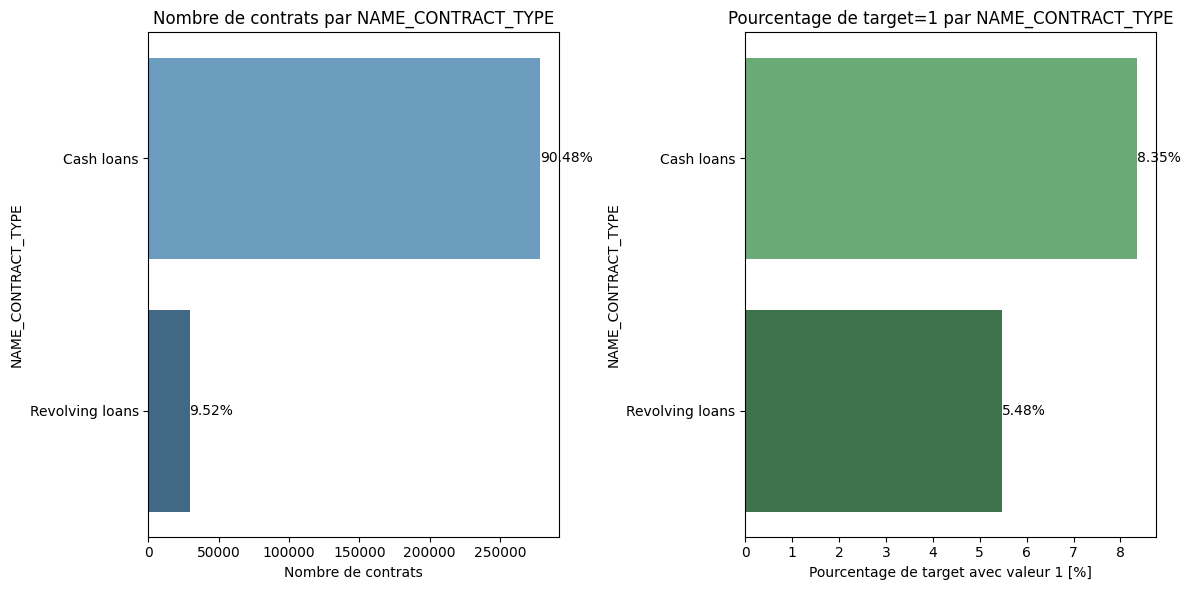

In [74]:
plot_stat('NAME_CONTRACT_TYPE')

***Le graphique montre que les prêts en espèces ("Cash loans") constituent la majorité des contrats (90,48%) et ont un taux de défaut (target=1) de 8,35%, tandis que les prêts renouvelables ("Revolving loans") représentent 9,52% des contrats avec un taux de défaut de 5,48%.***

#### <font color='Blue'> Client gender

***Observons le genre des clients et le pourcentage de prêts (par genre de client) ayant une valeur Target de 1, indiquant un prêt non remboursé.***

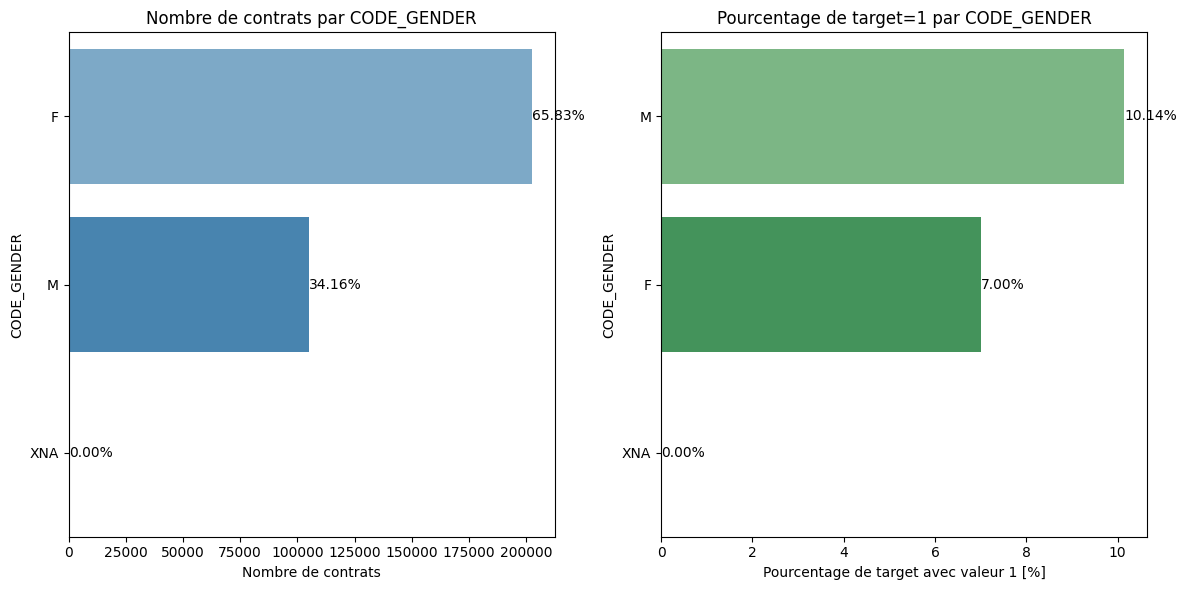

In [78]:
plot_stat('CODE_GENDER')

***Le graphique montre que les femmes (F) représentent 65,83% des contrats avec un taux de défaut de 7,00%, tandis que les hommes (M) représentent 34,16% des contrats avec un taux de défaut plus élevé de 10,14%.***

#### <font color='Blue'> Flag own car and flag own real estate

***Examinons les indicateurs nous renseignant sur la possession d'une voiture ou d'un bien immobilier par un client et, sur des graphiques distincts, observons le pourcentage de prêts (associé à la valeur de ces indicateurs) ayant une valeur Target de 1, indiquant un prêt non remboursé***

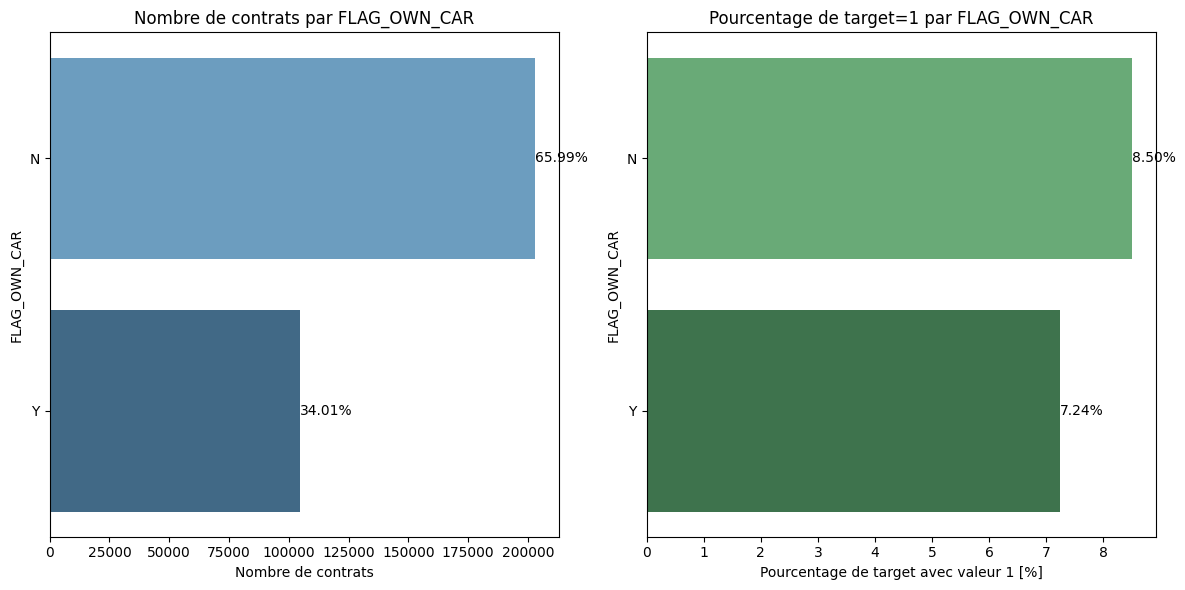

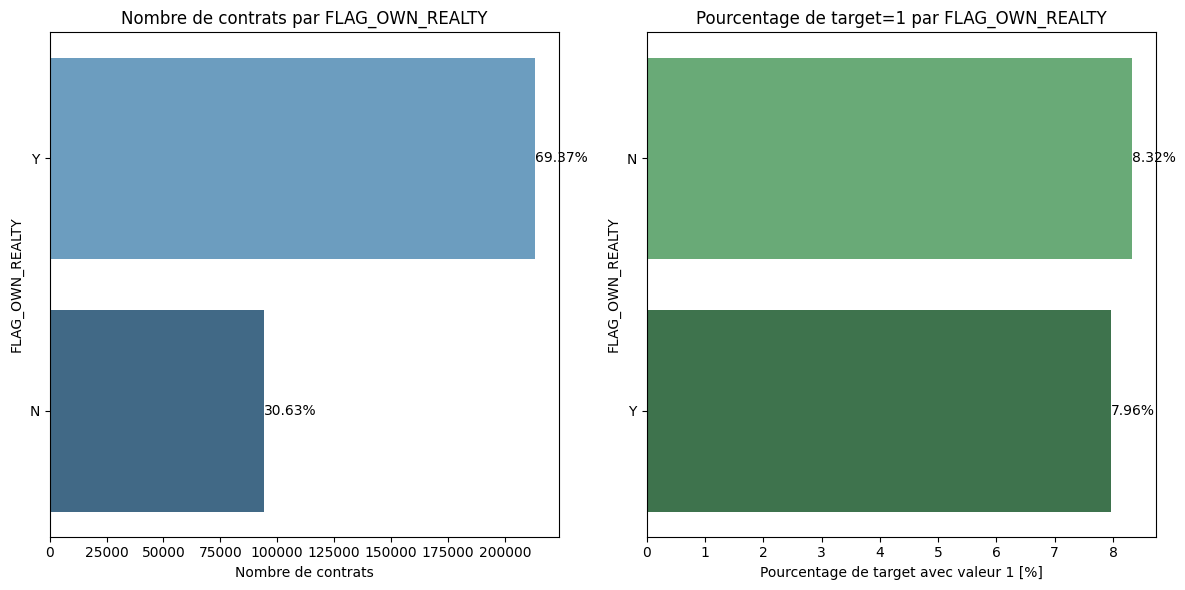

In [82]:
plot_stat('FLAG_OWN_CAR')
plot_stat('FLAG_OWN_REALTY')

***Les graphiques montrent que les clients sans voiture (N) représentent 65,99% des contrats avec un taux de défaut de 8,5%, tandis que ceux avec une voiture (Y) représentent 34,01% des contrats avec un taux de défaut de 7,24%; et que les clients possédant une propriété (Y) constituent 69,37% des contrats avec un taux de défaut de 7,96%, tandis que ceux sans propriété (N) représentent 30,63% des contrats avec un taux de défaut de 8,33%.***

#### <font color='Blue'> Client accompanied by

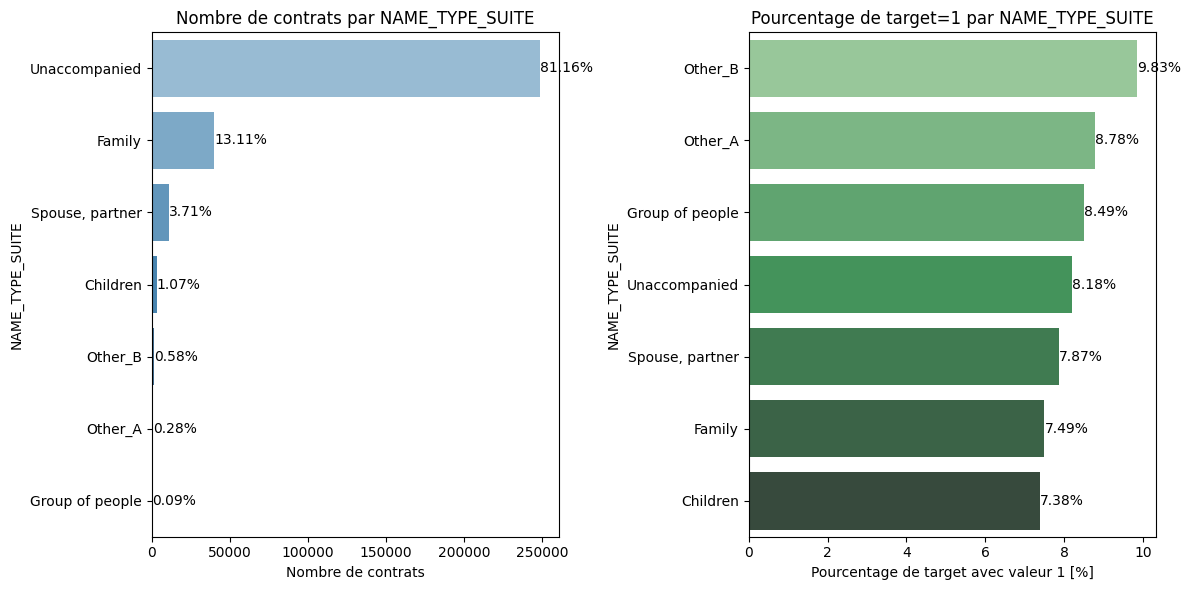

In [85]:
plot_stat('NAME_TYPE_SUITE',False, True)

***la majorité des contrats (81,16%) sont pour des clients non accompagnés ("Unaccompanied"), avec un taux de défaut de 8,18%, tandis que les clients en famille ("Family") représentent 13,11% des contrats avec un taux de défaut de 7,49%; les taux de défaut les plus élevés sont observés pour les catégories "Other_B" (9,83%) et "Other_A" (8,78%).***

#### <font color='Blue'> Family status of client

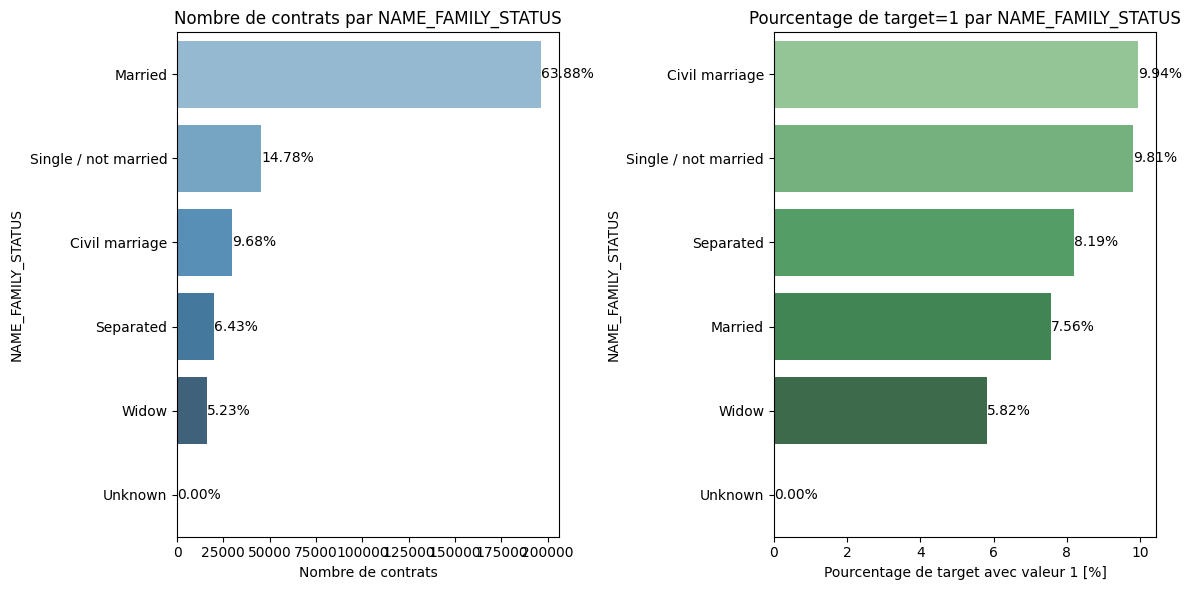

In [88]:
plot_stat('NAME_FAMILY_STATUS',False, True)

***La plupart des clients sont mariés, suivis par les célibataires/non mariés et ceux en union civile.
En ce qui concerne le pourcentage de non-remboursement de prêt, l'union civile présente le taux le plus élevé de non-remboursement (10 %), tandis que les veufs ont le taux le plus bas (à l'exception de la catégorie "Inconnu").***

#### <font color='Blue'> Number of children

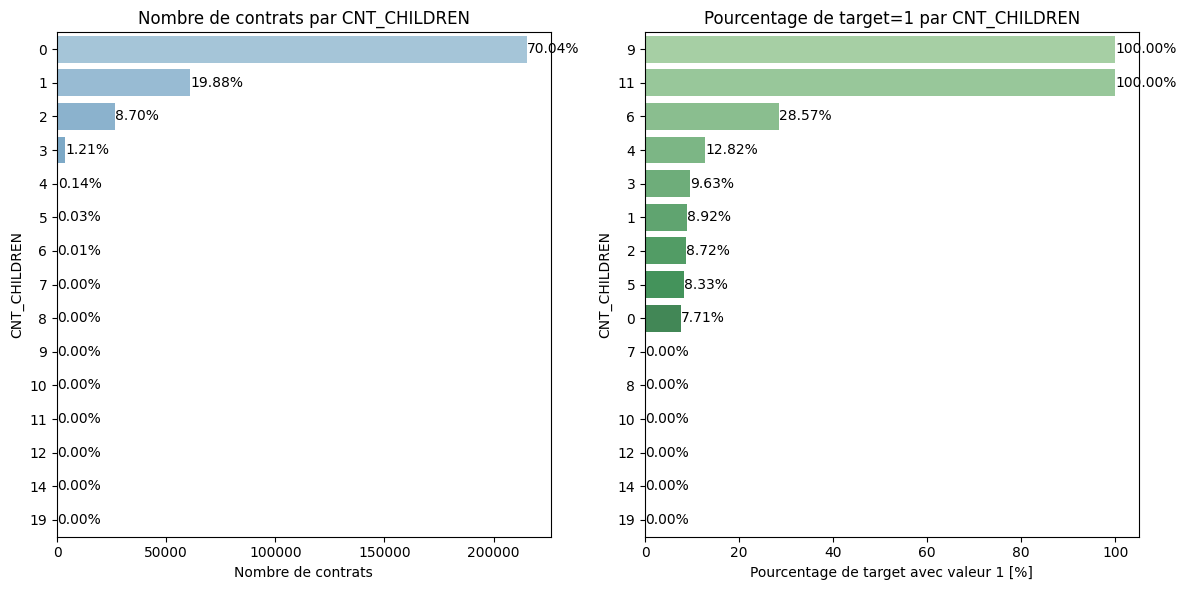

In [91]:
plot_stat('CNT_CHILDREN')

***Les graphiques montrent que la majorité des contrats sont pour des clients sans enfants (70,04%) avec un taux de défaut de 7,71%, tandis que les taux de défaut les plus élevés sont pour les clients ayant 6 enfants (28,57%) et 11 enfants (100%)***

#### <font color='Blue'> Number of family members of client

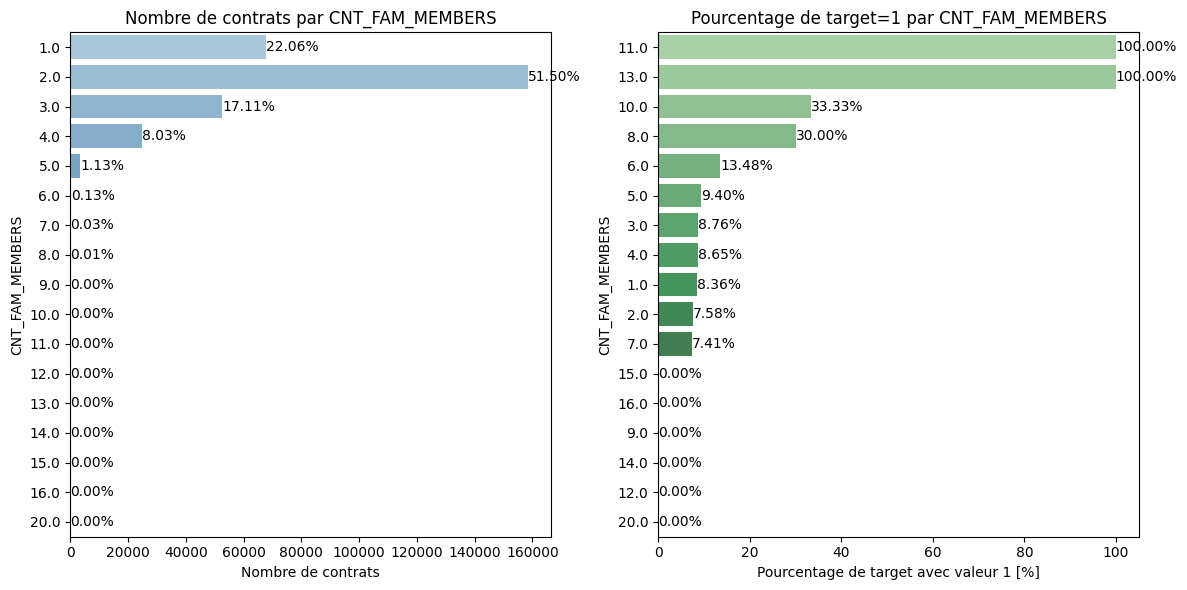

In [94]:
plot_stat('CNT_FAM_MEMBERS')

***Les graphiques montrent que la majorité des contrats concernent des clients avec 2 membres dans la famille (51,50%) et un taux de défaut de 8,36%, tandis que les taux de défaut les plus élevés sont observés pour les familles avec 11 et 13 membres (100%).***

#### <font color='Blue'> Income type of client

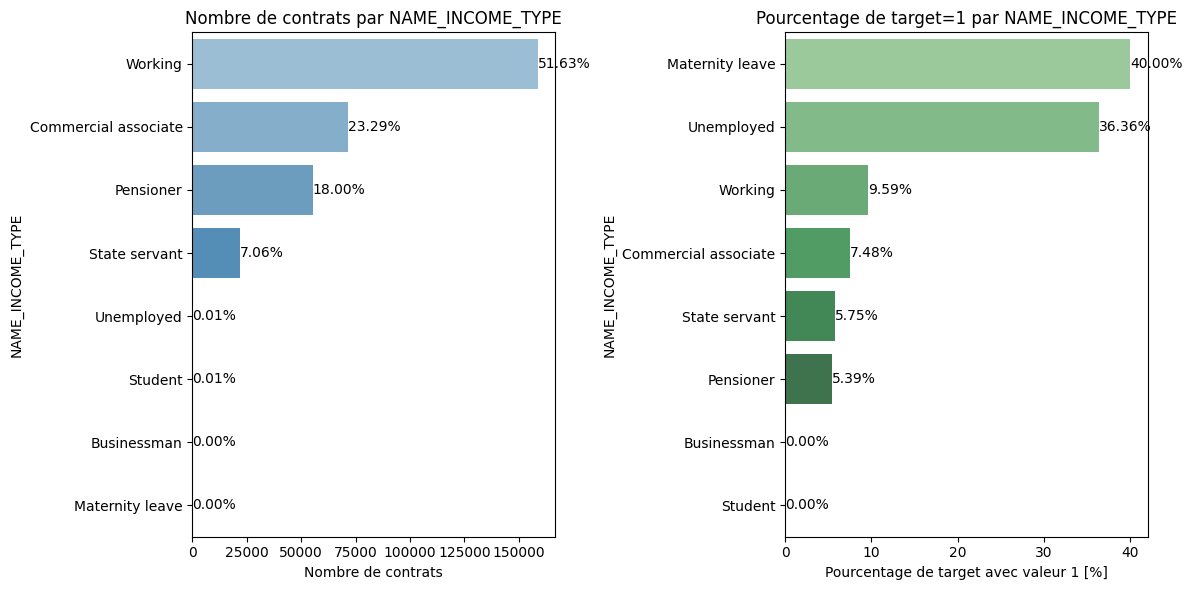

In [97]:
plot_stat('NAME_INCOME_TYPE',False,True)

***la majorité des contrats concernent des clients travaillant (51,63%) avec un taux de défaut de 9,59%, tandis que les taux de défaut les plus élevés sont observés pour les clients en congé de maternité (40,00%) et les clients sans emploi (36,36%).***

#### <font color='Blue'> Occupation of client

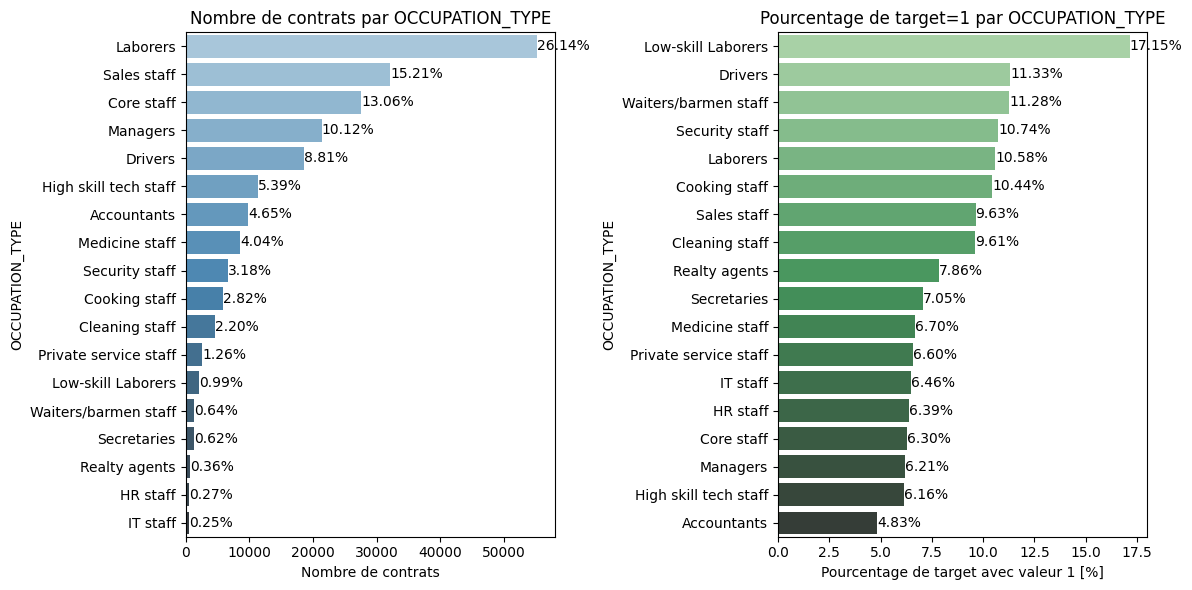

In [100]:
plot_stat('OCCUPATION_TYPE',False, True)

***la majorité des contrats concernent des ouvriers (26,14%) avec un taux de défaut de 10,58%, tandis que les taux de défaut les plus élevés sont observés pour les ouvriers non qualifiés (17,15%) et les chauffeurs (11,33%).***

#### <font color='Blue'> Organization type

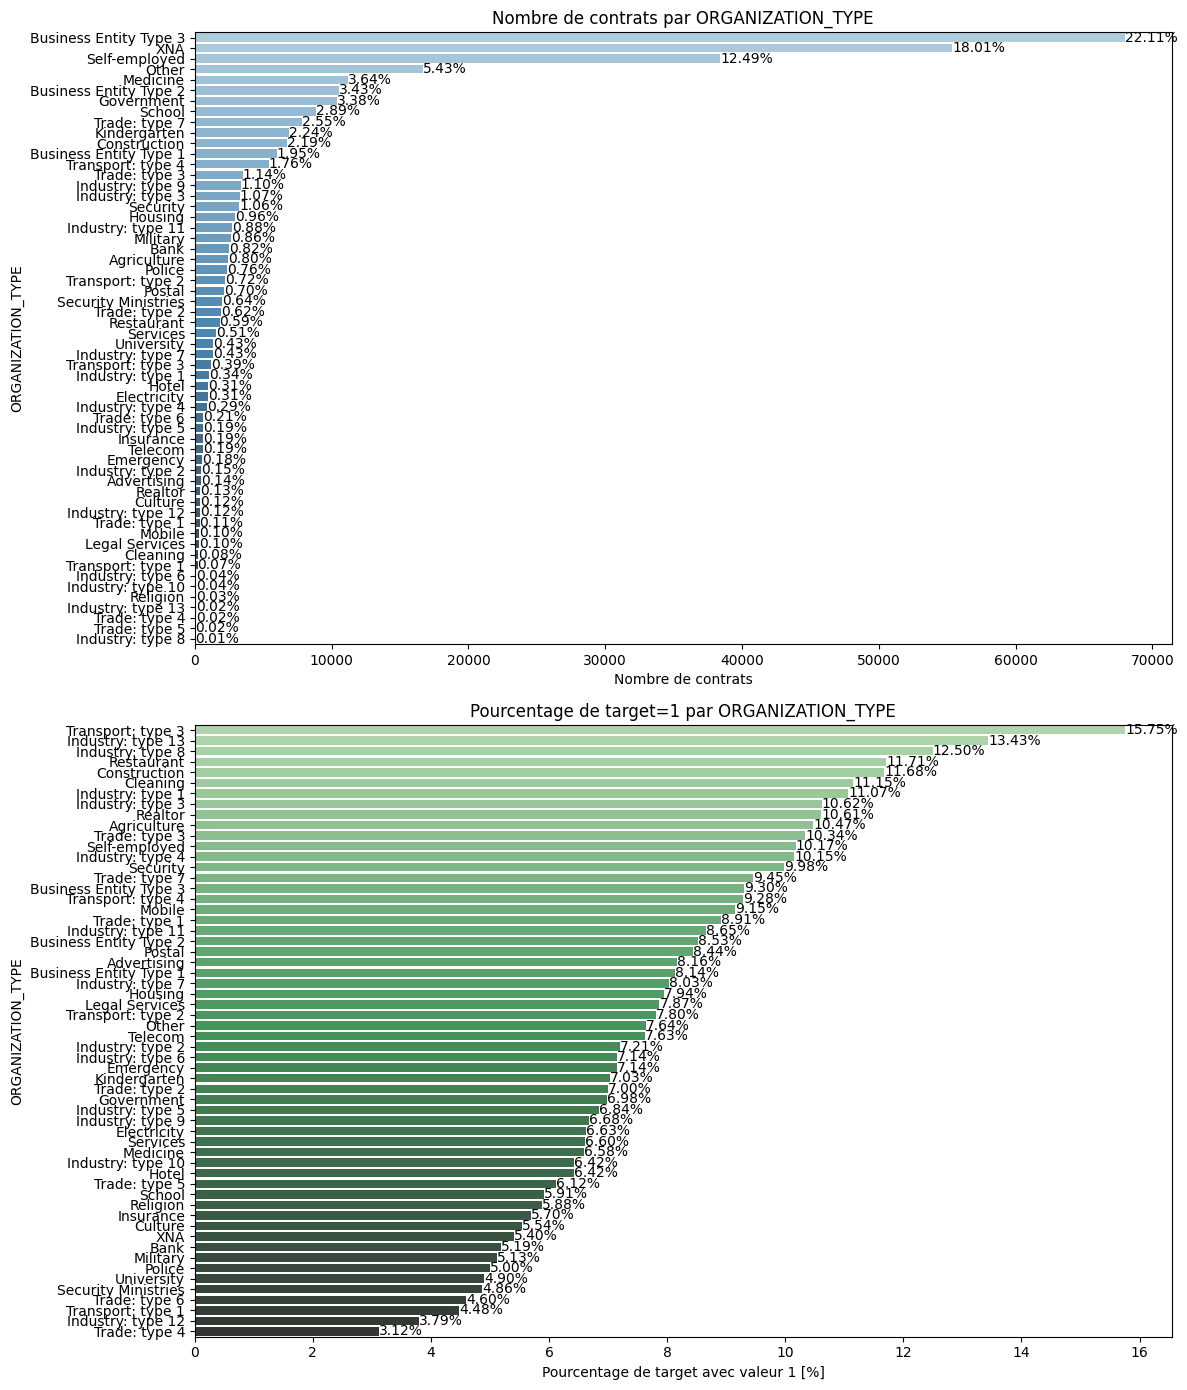

In [103]:
plot_stat('ORGANIZATION_TYPE',False,False)

***Les organisations affichant le pourcentage le plus élevé de prêts non remboursés sont celles dans le secteur des Transports : type 3 (16 %), l'Industrie : type 13 (13,5 %), l'Industrie : type 8 (12,5 %) et le secteur de la Restauration (moins de 12 %).***

#### <font color='Blue'> Education type of the client

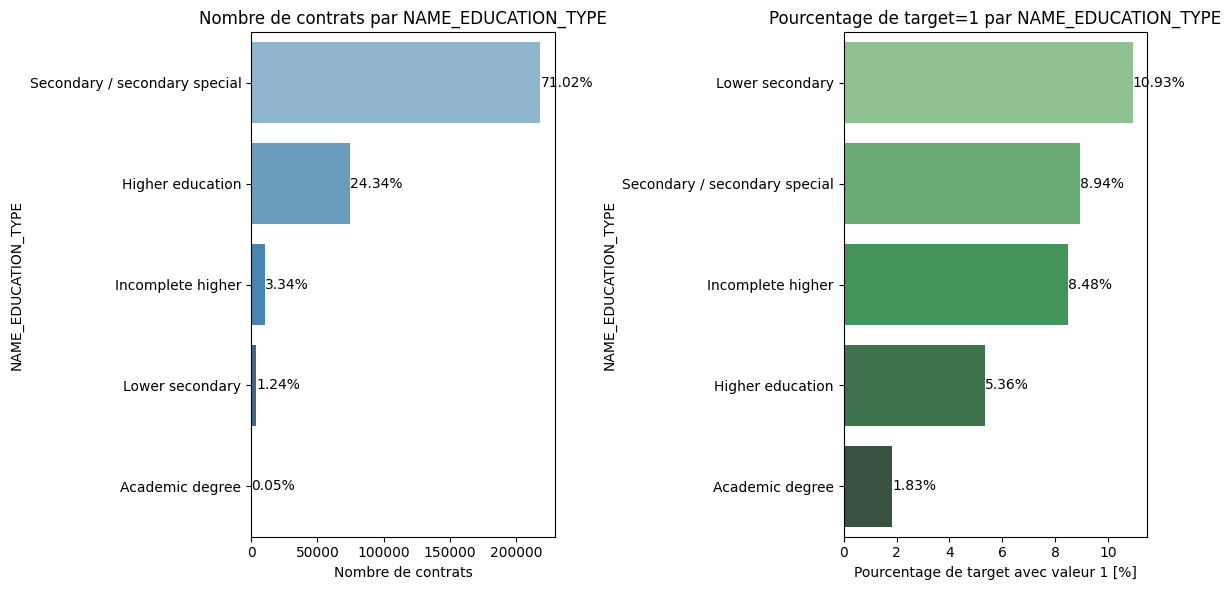

In [106]:
plot_stat('NAME_EDUCATION_TYPE')

***la majorité des contrats sont pour des clients ayant un niveau d'éducation "Secondary / secondary special" (71,02%) avec un taux de défaut de 8,94%, tandis que les taux de défaut les plus élevés sont observés pour les clients avec un niveau "Lower secondary" (10,93%).***

#### <font color='Blue'> Type of the housing of client

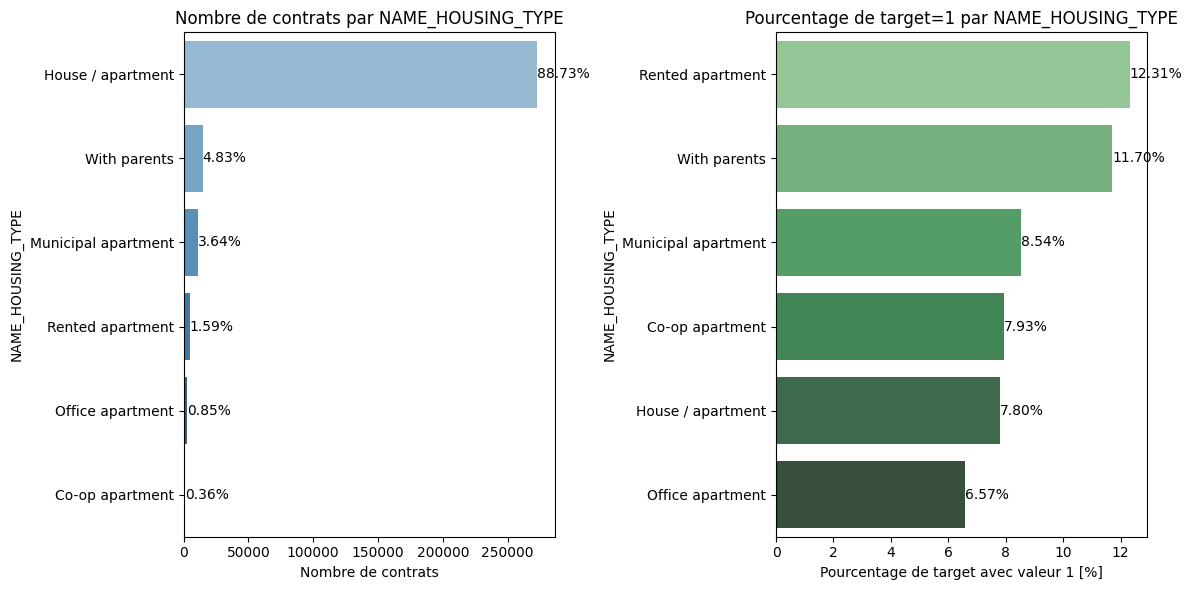

In [109]:
plot_stat('NAME_HOUSING_TYPE')

***Les graphiques montrent que la majorité des contrats concernent des clients vivant dans des maisons ou des appartements, tandis que les taux de défaut les plus élevés sont observés pour les clients vivant dans des appartements loués et chez leurs parents.***

#### <font color='Blue'> Total income distribution

In [112]:
#Tracer la distribution d'une caractéristique (feature) unique
def plot_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show()   

In [113]:
# Comparer les distributions de plusieurs caractéristiques pour les deux classes de la cible (TARGET = 0 et TARGET = 1)
def plot_distribution_comp(var,nrow=2):
    
    i = 0
    t1 = train.loc[train['TARGET'] != 0]
    t0 = train.loc[train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.legend(loc='best')
    plt.show()

In [114]:
train['AMT_INCOME_TOTAL'].min(),train['AMT_INCOME_TOTAL'].max()

(25650.0, 117000000.0)

***Le résultat montre que le revenu total des clients dans le jeu de données varie de 25 650 à 117 000 000, suggérant une très grande diversité dans les niveaux de revenus, ce qui pourrait nécessiter une attention particulière dans le prétraitement des données pour la construction d'un modèle de scoring précis et robuste.***

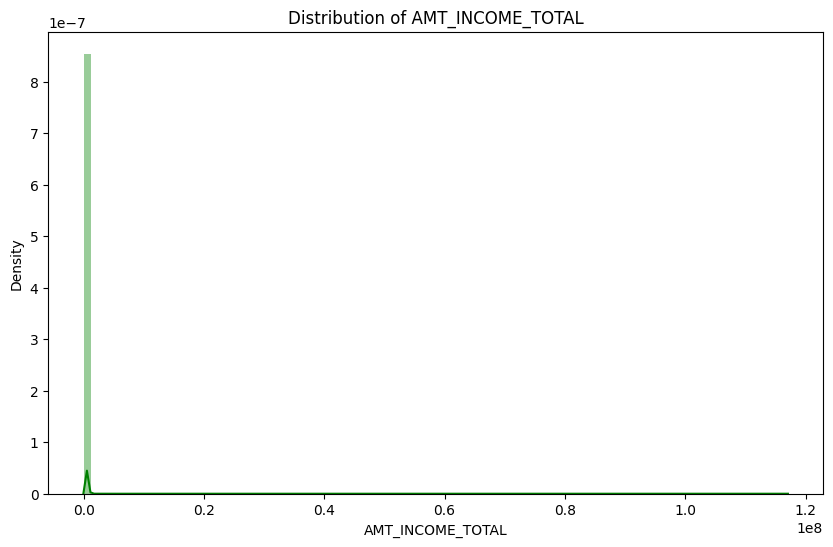

In [116]:
plot_distribution('AMT_INCOME_TOTAL','green')

#### <font color='Blue'> Credit distribution

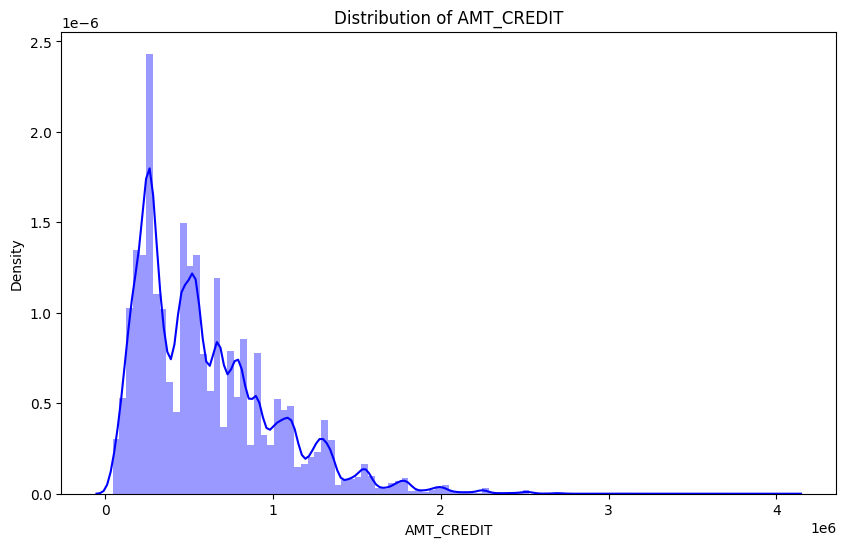

In [118]:
plot_distribution('AMT_CREDIT','blue')

***Le graphique montre la distribution des montants de crédit (AMT_CREDIT) avec une densité élevée pour les petits montants de crédit, qui diminue progressivement pour les montants plus élevés.***

#### <font color='Blue'> Annuity distribution

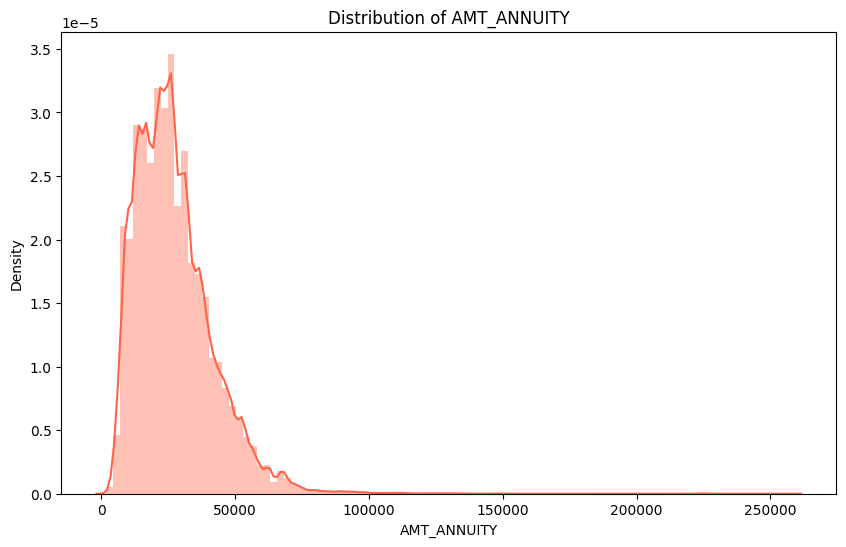

In [121]:
plot_distribution('AMT_ANNUITY','tomato')

***Le graphique montre la distribution des montants des annuités (AMT_ANNUITY), avec une densité élevée pour les petits montants d'annuités, qui diminue progressivement pour les montants plus élevés.***

#### <font color='Blue'> Goods price

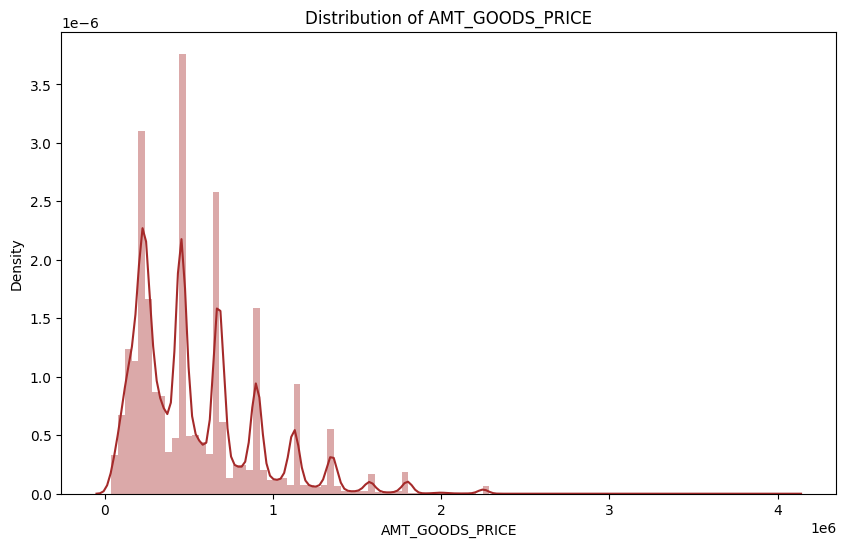

In [124]:
plot_distribution('AMT_GOODS_PRICE','brown')

***Le graphique montre que la plupart des biens achetés coûtent moins de 1 million, avec plusieurs pics de prix populaires. Très peu d'achats dépassent cette gamme, indiquant que les biens très chers sont rares.***

#### <font color='Blue'> Days from birth distribution

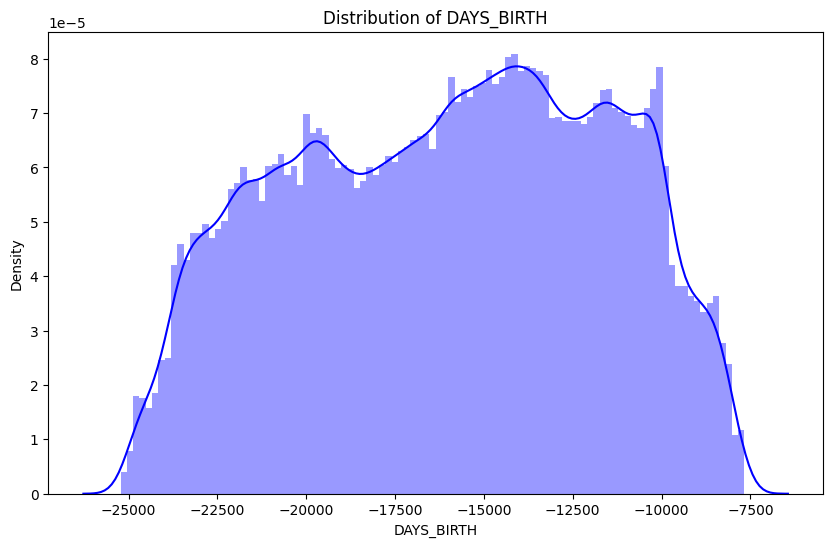

In [127]:
plot_distribution('DAYS_BIRTH','blue')

***Nous constatons une densité plus élevée pour les personnes ayant entre 27 et 68 ans, indiquant que la majorité des clients se situent dans cette tranche d'âge.***

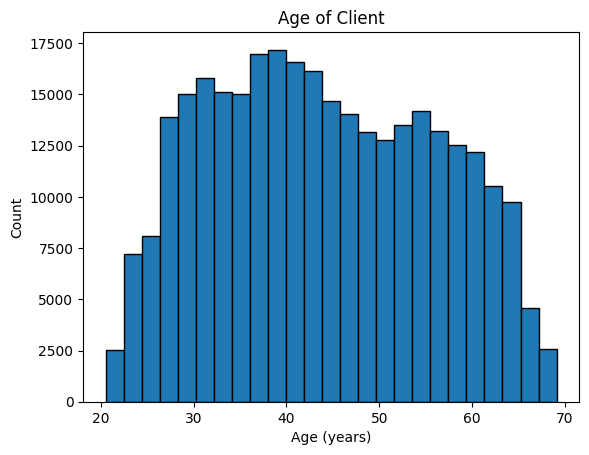

In [129]:
train['DAYS_BIRTH'] = abs(train['DAYS_BIRTH'])

# Plot the distribution of ages in years
plt.hist(train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

***Visualisons maintenant l'effet de l'âge sur la cible. Nous allons réaliser un graphique d'estimation de densité par noyau (kernel density estimation = KDE) coloré en fonction de la valeur de la cible.***

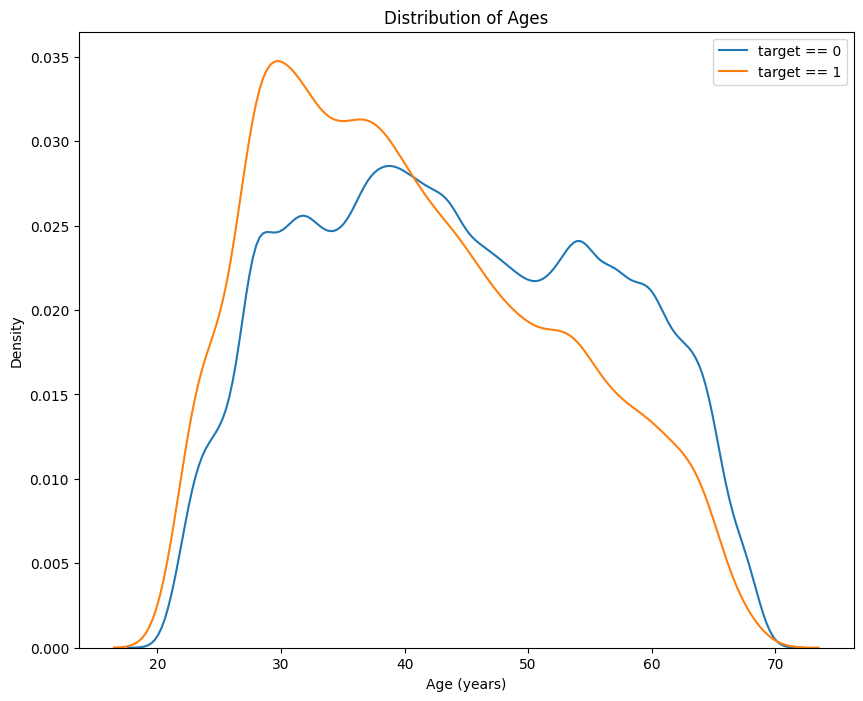

In [131]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')
plt.legend(loc='upper right')

***Le graphique montre la distribution des âges des clients, en comparant ceux qui ont remboursé leurs prêts à temps (target = 0) et ceux qui ne l'ont pas fait (target = 1).***
*****
***Les clients plus jeunes (environ 20-40 ans) ont un taux de non-remboursement plus élevé, tandis que les clients plus âgés (30-50 ans) sont plus susceptibles de rembourser leurs prêts à temps. Les personnes âgées de plus de 60 ans ont une densité plus faible de prêts, qu'ils soient remboursés ou non.***

#### <font color='Blue'> Days employed distribution

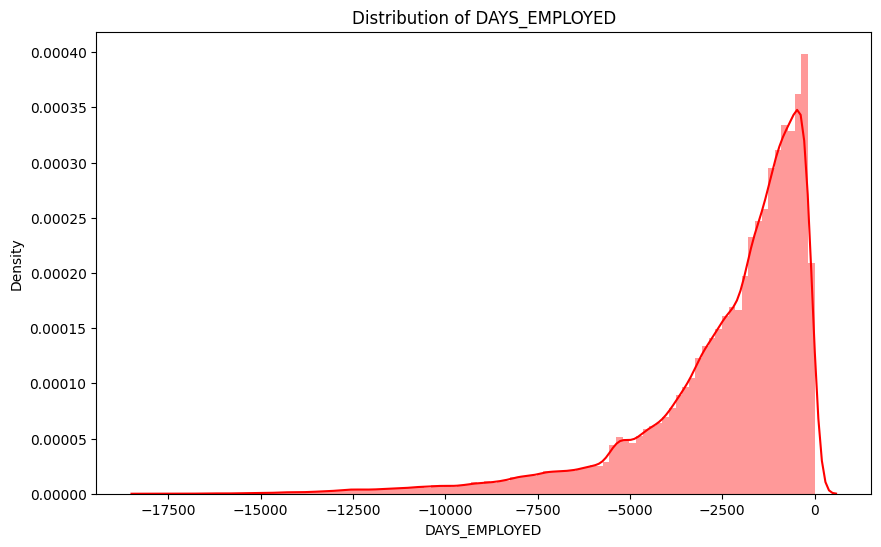

In [134]:
# Replace the anomalous values with nan
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

plot_distribution('DAYS_EMPLOYED','red')

***Le graphique représente le temps passé par les clients dans leur emploi actuel ou le dernier connu, avec la majorité ayant une ancienneté relativement récente et une minorité ayant une longue ancienneté.***

#### <font color='Blue'> Days of registration distribution

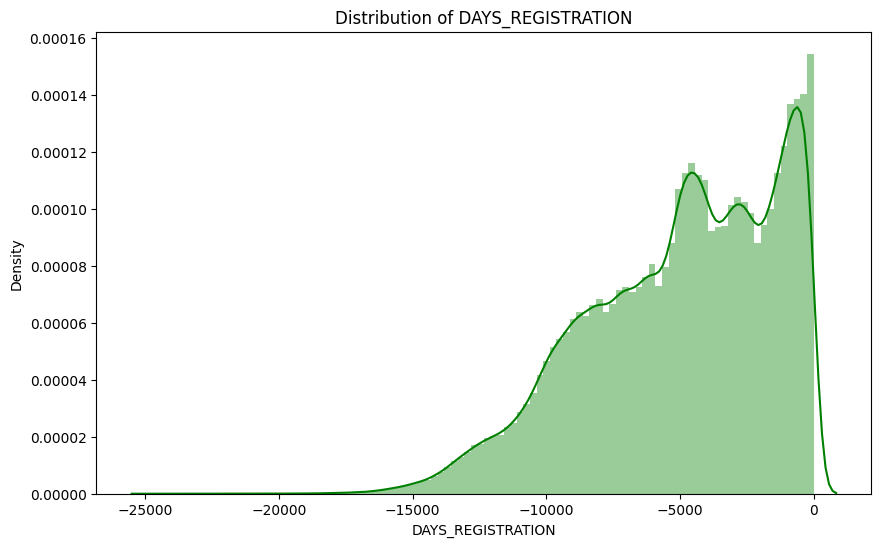

In [137]:
plot_distribution('DAYS_REGISTRATION','green')

***Le graphique représente quand les clients ont enregistré leurs crédits, avec une tendance indiquant que beaucoup l'ont fait plus proche de la date actuelle.La majorité des enregistrements se sont produits récemment, avec quelques périodes distinctes dans le passé où un nombre notable de personnes se sont également enregistrées.***

#### <font color='Blue'> Region registered not live region and not work region

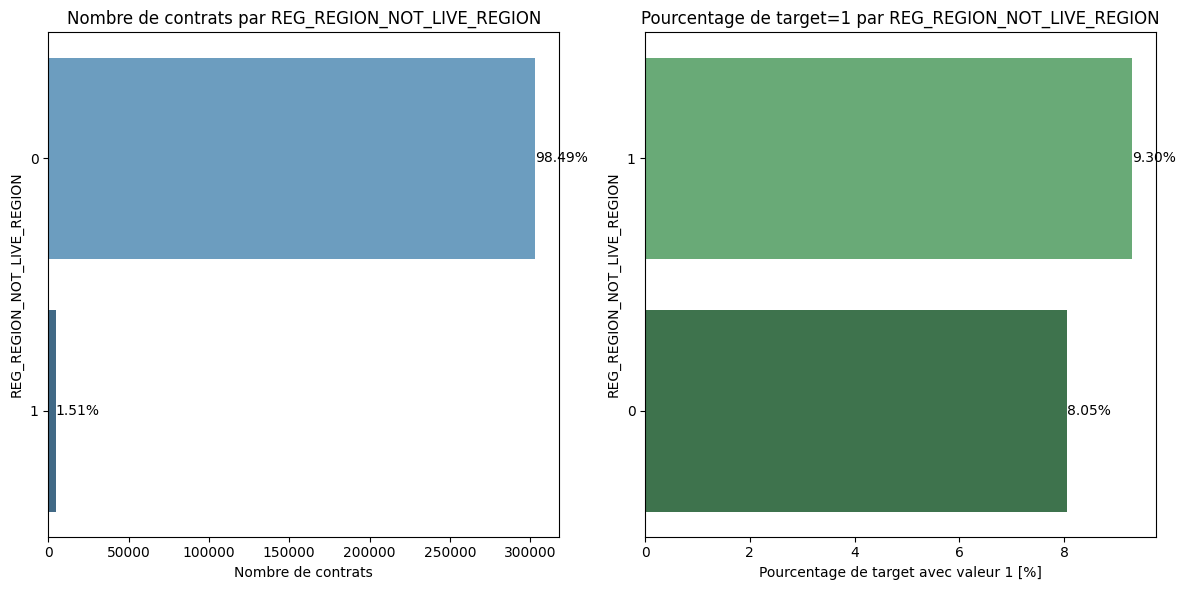

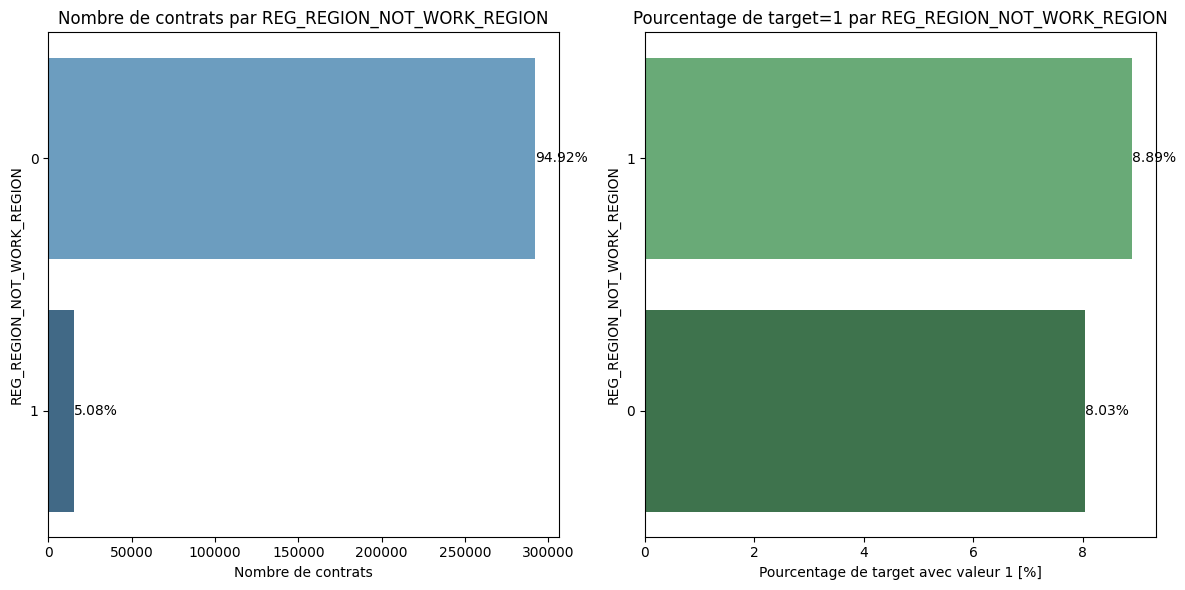

In [140]:
plot_stat('REG_REGION_NOT_LIVE_REGION')
plot_stat('REG_REGION_NOT_WORK_REGION')

#### <font color='Blue'> City registered not live city and not work city

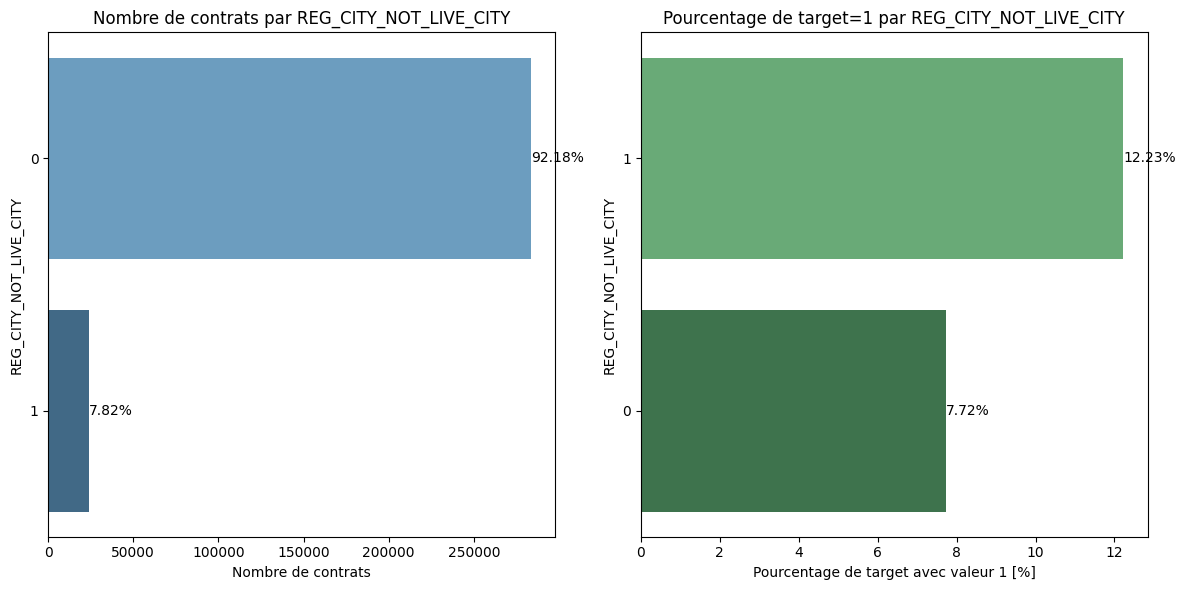

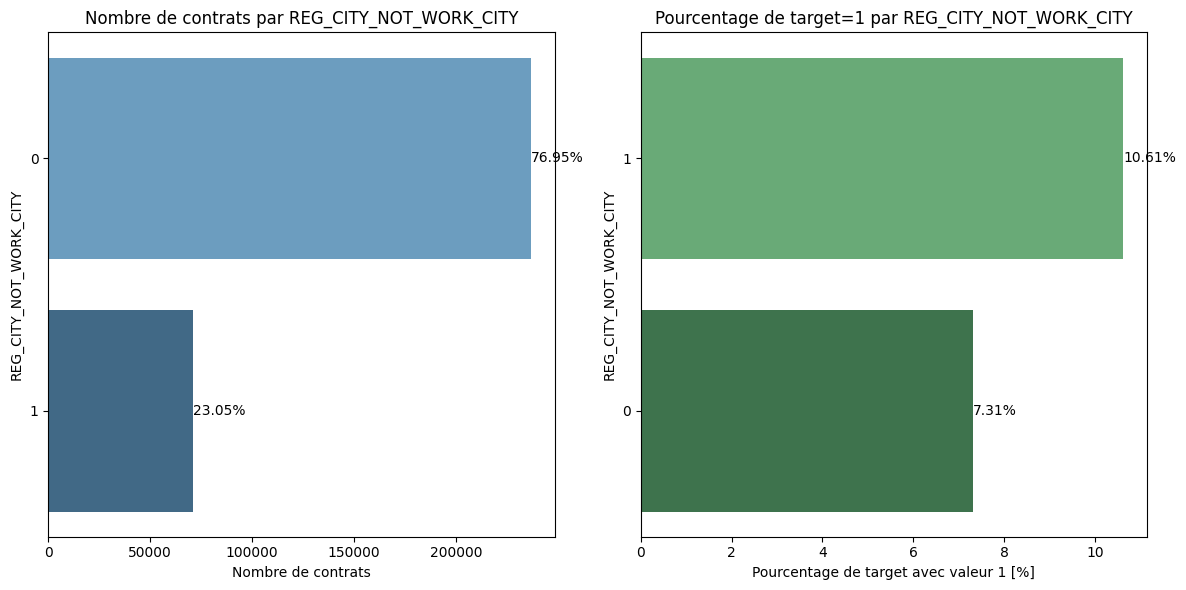

In [142]:
plot_stat('REG_CITY_NOT_LIVE_CITY')
plot_stat('REG_CITY_NOT_WORK_CITY')

## <span style='background:PowderBlue'> 4. Correlations

In [144]:
# Sélectionner uniquement les colonnes numériques
numerical_columns = train.select_dtypes(include=['number'])

# Calculer les corrélations avec la colonne TARGET
correlations = numerical_columns.corr()['TARGET'].sort_values()

# Afficher les corrélations
print('Correlations les plus positives:\n', correlations.tail(10))
print('\Correlations les plus négatives:\n', correlations.head(10))

Correlations les plus positives:
 FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
TARGET                         1.000000
Name: TARGET, dtype: float64
\Correlations les plus négatives:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_BIRTH                   -0.078239
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64


***Les variables les plus corrélées positivement avec la cible (TARGET) sont FLAG_DOCUMENT_3, REG_CITY_NOT_LIVE_CITY, et FLAG_EMP_PHONE, tandis que les variables les plus corrélées négativement avec la cible sont EXT_SOURCE_3, EXT_SOURCE_2, et EXT_SOURCE_1. Les corrélations négatives des sources externes suggèrent que des scores plus élevés de ces sources sont associés à une probabilité plus faible de défaut de paiement, ce qui en fait des indicateurs importants pour évaluer le risque de crédit.***

## <span style='background:PowderBlue'> 5. Identifier les cibles déséquilibrées

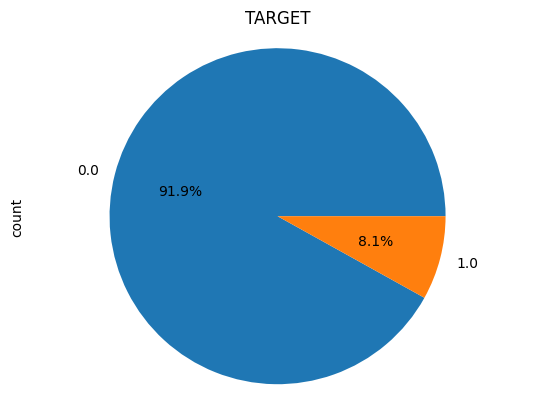

In [147]:
# Sélectionner la variable cible
cat_vars = ['TARGET']

# Générer un pie plot pour la variable cible
for var in cat_vars:
    df[var].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title(var)
    plt.axis('equal')
    plt.show()

- **Distribution des Valeurs de "TARGET" :** environ 8% des clients présentent un défaut de paiement, tandis que 92% n'en ont pas.

- **Déséquilibre des Classes :**
        Le graphique montre un déséquilibre significatif entre les deux classes de "TARGET". La classe 0 est beaucoup plus représentée que la classe 1.
        Ce type de déséquilibre est commun dans les problèmes de classification binaire, en particulier dans les applications de détection de fraude, de détection de défaut de crédit, etc.

- **Implications du Déséquilibre des Classes**

    - Impact sur le Modèle :
        Les modèles de machine learning peuvent être biaisés vers la classe majoritaire (0 dans ce cas), car ils cherchent à maximiser l'exactitude globale. Cela peut conduire à une mauvaise performance sur la classe minoritaire (1), ce qui est souvent la classe d'intérêt dans de nombreux problèmes.
    - Nécessité de Techniques d'Equilibrage :
       -  Pour améliorer la performance du modèle sur la classe minoritaire, des techniques d'équilibrage des classes peuvent être nécessaires, telles que le suréchantillonnage de la classe minoritaire, le sous-échantillonnage de la classe majoritaire, ou l'ajustement des poids des classes (class_weight) dans les modèles de machine learning.

#### <font color='Blue'> 5.1 Prétraitement des Données pour la Modélisation

In [150]:
# Calcul du pourcentage de valeurs nulles
nulls = df.isnull().sum().to_frame('nulls').reset_index()
nulls['percentage'] = round((nulls['nulls'] / 356251) * 100)

# Liste des colonnes à supprimer (celles qui ont plus de 25% de valeurs nulles)
list_drop = nulls["index"][nulls["percentage"] >= 25].tolist()

# Suppression des colonnes sélectionnées
df = df.drop(columns=list_drop)

# Transformation de la colonne TARGET en type int8 (car elle est binaire)
df['TARGET'].fillna(value=99, inplace=True)
df['TARGET'] = df['TARGET'].astype('int8')
df['TARGET'].replace(-99, np.nan, inplace=True)

# Transformation de différentes colonnes en différents types numériques pour réduire l'utilisation de la mémoire
for col in df.columns:
    if df[col].dtype == "int64" and df[col].nunique() == 2:
        df[col] = df[col].astype("int8")
    if df[col].dtype == "float64" and df[col].min() >= -2147483648 and df[col].max() <= 2147483648:
        df[col] = df[col].astype("float32")

# Remplacer les valeurs infinies par NaN
inf_cols = df.columns.to_series()[np.isinf(df).any()]
for col in inf_cols:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)

# Affichage des informations du DataFrame après transformation
df.info()

# Obtenir les colonnes qui ont des valeurs nulles
nan_cols = [i for i in df.columns if i != "TARGET" and df[i].isnull().any()]

# Remplacer les valeurs nulles par la moyenne
for col in nan_cols:
    df[col].fillna(value=df[col].mean(), inplace=True)

# Afficher le pourcentage de valeurs nulles par colonne
df.loc[:, df.isna().any()].isnull().sum() * 100 / len(df)

<class 'pandas.core.frame.DataFrame'>
Index: 356251 entries, 0 to 356254
Columns: 509 entries, SK_ID_CURR to INSTAL_COUNT
dtypes: bool(133), float32(327), float64(6), int64(7), int8(36)
memory usage: 539.9 MB


Series([], dtype: float64)

In [151]:
df['TARGET'].dtypes

dtype('int8')

#### <font color='Blue'> 5.2 Formattage des Colonnes et Réduction de la Corrélation des Données

    - Formattage des Noms de Colonnes :
        Assure que les noms de colonnes sont conformes et ne contiennent pas de caractères spéciaux pouvant causer des erreurs.

    - Réduction de la Corrélation :
        Évite les redondances et le surajustement en supprimant les colonnes fortement corrélées entre elles.

    - Identification des Variables Importantes :
        Met en évidence les variables les plus fortement corrélées avec la cible, aidant ainsi à la sélection des caractéristiques et à la construction de modèles plus interprétables et efficaces.

In [ ]:
# Formattage des noms de colonnes
import re
df = df.rename(columns=lambda x: re.sub(r'[^A-Za-z0-9_]+', '', x))

# Créer une liste des colonnes à supprimer : celles qui sont fortement corrélées avec la cible
corr = df.drop(columns=["TARGET"]).corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

# Supprimer les colonnes corrélées
df = df.drop(columns=to_drop)

# Obtenir toutes les valeurs de corrélation
corr = df.corrwith(df['TARGET']).abs()

# Afficher les colonnes qui ont une corrélation supérieure à 0,8 avec la cible
corr[corr > 0.8]

## <span style='background:PowderBlue'> 6. Exportation des données

In [ ]:
# Exporter le DataFrame en un fichier CSV
df.to_csv('data_cleaned.csv', index=False)

print("Les données nettoyées ont été exportées avec succès.")

In [ ]:
pd.DataFrame(X_train_smote).to_csv('df_train.csv',index=False)